# Colony Image processing
##  From stacked tif images to angular and pair correlation metric

#### Import used packages

In [18]:
using Pkg
Pkg.status()
Pkg.instantiate()

Project ColonyImages v1.0.0-DEV
Status `C:\Users\ank10ki\Dropbox\phd\Image analysis\ColonyImages\Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
  [e30172f5] Documenter v1.1.2
  [7a1cc6ca] FFTW v1.7.1
  [5789e2e9] FileIO v1.16.1
  [916415d5] Images v0.26.0
  [10745b16] Statistics v1.9.0


In [19]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO

In [20]:
#using Images, FileIO, BenchmarkTools, CairoMakie, Dates
#using FFTW, Revise, DataFrames, Chain, DataFramesMeta, StatsBase, Serialization, CSV, ColonyImages

#### Create empty data frame to store metrics together with colony ids and age of colony  

In [21]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),OG_size = Int[])

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64


#### Check which data sets are available in data folder

In [22]:
image_data = "data\\image_data_stacked\\"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  10_04_23_stacked_half_res
2  14_06_23_stacked_full_res
3  14_06_23_stacked_half_res
4  17_05_23_stacked_full_res
5  17_05_23_stacked_half_res
6  19_12_22_stacked_full_res
7  26_06_23_stacked_full_res
8  27_04_22_stacked_full_res_expo
9  27_04_22_stacked_half_res_expo
10  28_03_23_stacked_half_res


#### Chose dataset 
Image pipeline has been created for stacked tif images. Image data needs to be in that format for pipeline to work correctly.  

In [23]:
data_set = readdir(image_data)[7]
path = joinpath(image_data, data_set)
readdir(path)

14-element Vector{String}:
 "Kolonie-1 seg manuell.tif"
 "Kolonie-2 seg manuell.tif"
 "Kolonie-3 seg manuell.tif"
 "Kolonie-4 seg manuell.tif"
 "Kolonie-5 seg manuell.tif"
 "Kolonie-6 seg manuell.tif"
 "Kolonie-7 seg manuell.tif"
 "Kolonie-8 seg manuell.tif"
 "angular&pair.png"
 "methos_compare_centroid.png"
 "methos_compare_cov.png"
 "methos_compare_cov_shown.png"
 "show_cov.png"
 "timepoints.csv"

The time series colony images have been take at certain dates/times T(n) (where n is the number of time points). The specific dates can be found in the meta data of the raw tif images. Here only the relative time points are relevant, therefore first images are set to T_r(1) = 0 and the following to the next full hours of T(n)_r = T(n)-T(1). The time points are stored in a `csv` file called `timepoints.csv` next to the image data. If `timepoints.csv` does not exist already, it will be created manually by the cell below. 

In [24]:
if "timepoints.csv" ∉ readdir(path)
    
    df2 = DataFrame(time = Float64[0,20,24,44])
    
    if length(df2.time) != size(load(joinpath.(path, filter(x->x[end-2:end]=="tif",readdir(path)))[1]))[3]
        println("ERROR ERROR ERROR ")
    else
        CSV.write(joinpath(path,"timepoints.csv"), df2)   
    end
else println("df already existing")
end

time_points = CSV.read(joinpath(path,"timepoints.csv"), DataFrame).time

df already existing


6-element Vector{Float64}:
  0.0
  3.0
 19.0
 24.0
 43.0
 48.0

All `tif` files inside chosen folder are loaded into img_vec with is a vector of stacked images(3 dimensional (x,y,t) arrays). 

In [25]:
colonies = filter(x->x[end-2:end]=="tif",readdir(path))
img_vec  = load.(joinpath.(path, colonies));

#### Parameters for Image analysis :

`relative_size_filles_holes` defines how big the holes inside a colony can be relative to the image size, that are filled automatically with the `fill_holes` function. 

`threshold_conv`, `threshold_c` and `kernel_ratio` are all parameter of the convolution process, which is explained in more detail below. For typical images they should remain at their default values:
```julia 
threshold_conv = 0.8
threshold_c = 0.8
kernel_ratio = 0.4
```

`Points` is a vector of vectors of `Lattice vectors` in ascending order by their length . Whereas the first entry of `Points` contains a vector of all lattice vectors which lengths are lower than 2:
```julia
Points[1] = [[0, 1], [0, 1], [0, -1], [0, -1], [1, 0], [-1, 0], [1, 0], [-1, 0], [1, 1], [-1, 1], [1, -1], [-1, -1]]
```
`Points[2]` does the same for length lower than 3:
```julia
Points[2] = [[0, 2], [0, 2], [0, -2], [0, -2], [2, 0], [-2, 0], [2, 0], [-2, 0], [1, 2], [-1, 2], [1, -2], [-1, -2], [2, 1], [-2, 1], [2, -1], [-2, -1], [2, 2], [-2, 2], [2, -2], [-2, -2]]
```
and so on...
The `Points` vectors is latter needed to fit a circle onto the reduced colony. 


`steps_angular` defines the number of steps in the angular metric around a unit circle. For its default value 
```julia
steps_angular = 360
```
every steps is 1° degree wide. 

`samples_pair` defines how many random pair of lattice points are sampled for the pair correlation metric. A higher number here is always better for the precision. The only limiting factor here is computation time (and at some point probably memory). Its default values is: 

```julia
samples_pair = 2000000
```


In [34]:
# automatically inverts and converts images to black and white (binary) if not already 
img_int_vec = b_w.(img_vec);
# 
relative_size_filles_holes = 0.01
img_int_vec = fill_holes.(img_int_vec,[relative_size_filles_holes for x in length(img_int_vec)]);
# threshold_conv has to be lowered for not homogenoulsy filled colonies
threshold_conv = 0.8
threshold_c = 0.8
# kernel ratio is given against approximate site of colony calculated by occupied points
kernel_ratio = 0.4
Points = lattice_points(maximum(maximum.(size.(img_int_vec)))÷2);
steps_angular = 360

# the more the better, only limited by computation time
samples_pair = 2000000;


### Convolution explanation 

In [35]:
int_img = img_int_vec[end][:,:,4]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(img_int_vec[5][:,:,1])*kernel_ratio), geometry = "square")
nneigh = sum(kernel)
out = conv(int_img, kernel ) ./ nneigh;

In [36]:
fontsize_theme = Theme(fontsize = 28)
update_theme!(fontsize_theme)

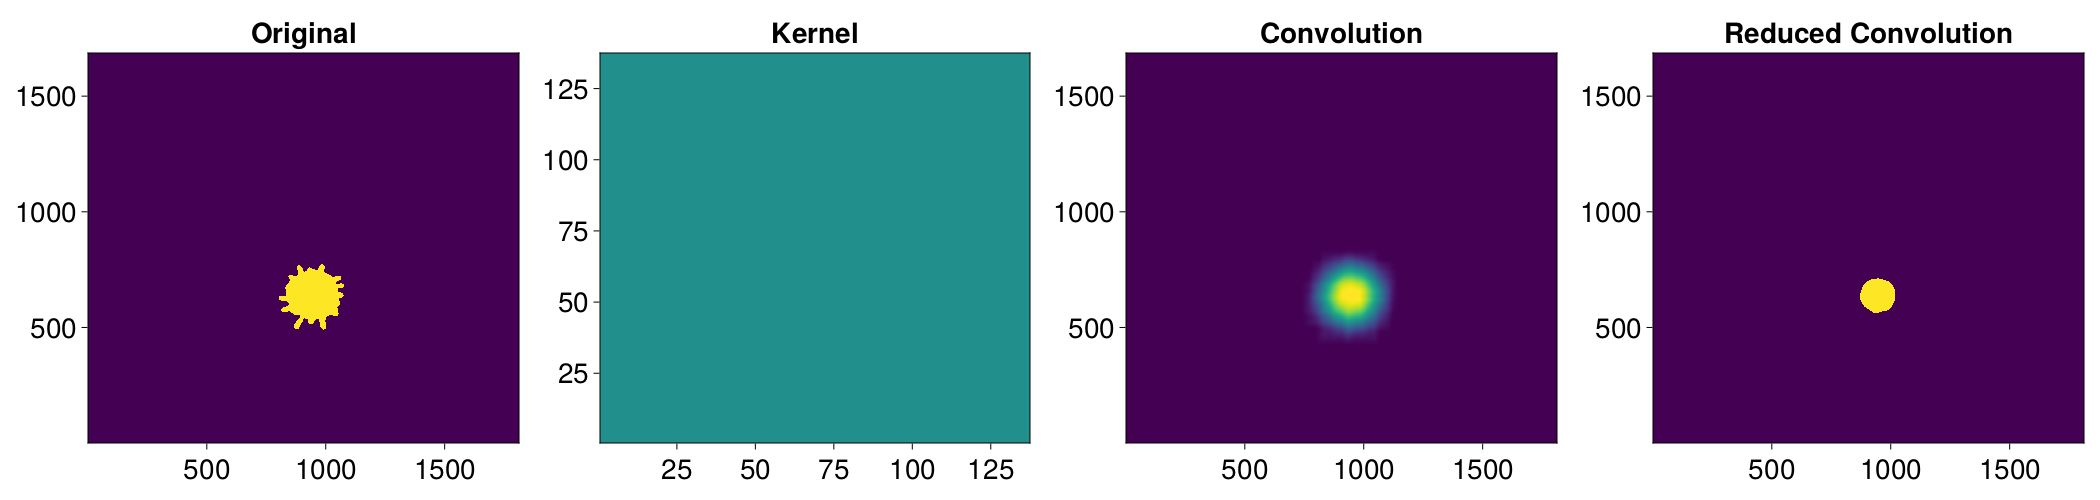

In [37]:
comp_conv = Figure(resolution = (2100,500))
ax_1 = CairoMakie.Axis(comp_conv[1,1], title = "Original")
heatmap!(ax_1, int_img)
ax_2 = CairoMakie.Axis(comp_conv[1,2], title = "Kernel")
heatmap!(ax_2, kernel)
ax_3 = CairoMakie.Axis(comp_conv[1,3], title = "Convolution")
heatmap!(ax_3, out)
ax_4 = CairoMakie.Axis(comp_conv[1,4], title = "Reduced Convolution")
heatmap!(ax_4, out.>threshold_conv)


save(joinpath(path,"show_cov.png"), comp_conv)
comp_conv

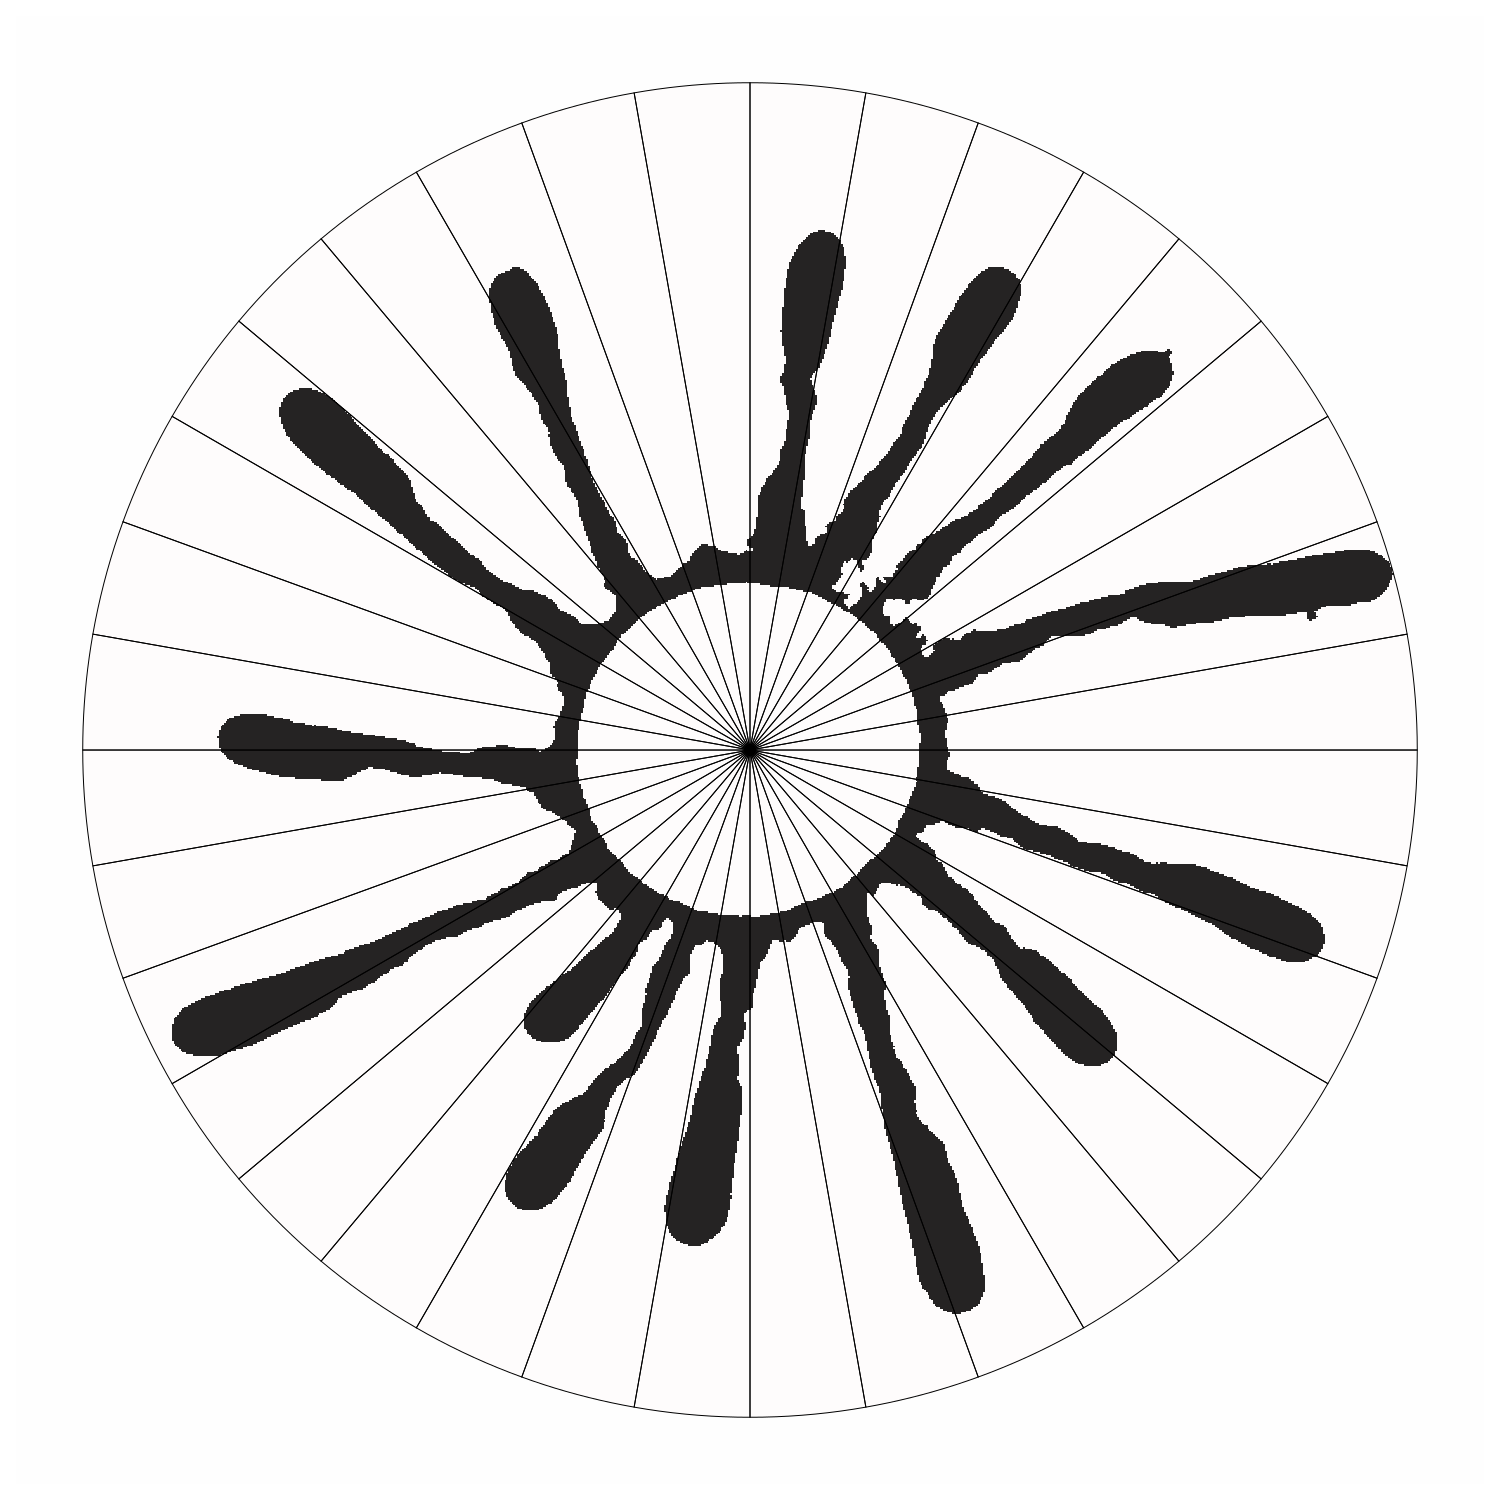

In [15]:
fig_89 = Figure(resolution =(1500,round(Int,1500)))
int_img = img_int_vec[7][:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)

int_img = img_int_vec[2][:,:,6]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img = rotr90(int_img)
x = 420
y_o = 150
x_o = -3


int_img = int_img[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]
int_fac = round(Int,(1-0.8705035971223022)*size(int_img)[1]/2)

int_img = int_img[:,int_fac: end-int_fac]
out = conv( int_img, kernel ) ./ nneigh
y_c, x_c = centroid(out .> threshold_conv)
y,x = centroid(int_img)
ax = CairoMakie.Axis(fig_89[1,1])
ax2 = CairoMakie.Axis(fig_89[1,1])
hidedecorations!(ax2)
hidedecorations!(ax)

hidespines!(ax)
hidespines!(ax2)

circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
#heatmap!(ax,int_img,colormap = (:hawaii,1.0))
#heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
#heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))

int_img_1 = img_int_vec[2][:,:,1]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img_1 = rotr90(int_img_1)
x = 420
y_o = 150
x_o = -3
int_img_1 = int_img_1[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]

int_fac = round(Int,(1-0.8705035971223022)*size(int_img_1)[1]/2)

int_img_1 = int_img_1[:,int_fac: end-int_fac]

#heatmap!(ax,int_img,colormap = (:grayC10,1.0))

heatmap!(ax,(int_img.-int_img_1).*-1,colormap = (:grayC10,1.0))
#heatmap!(ax,int_img_1, colormap  =(:thermal, 0.5))
#scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")

#scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
#scatter!(ax,y_c, x_c, color = :black, markersize = 45, label = "Centroid")
pie_data = [1 for i in 1:10:360]
pie!(ax2,pie_data,radius = 10, color = (:red, 0.01))
#axislegend(ax)
fig_89

In [16]:
#save("schematics/angular_metric_sheme.png", fig_89)

In [15]:
int_img = img_int_vec[2][:,:,6]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img = rotr90(int_img)
x = 420
y_o = 150
x_o = -3
int_img = int_img[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]
size(int_img)

847/973

0.8705035971223022

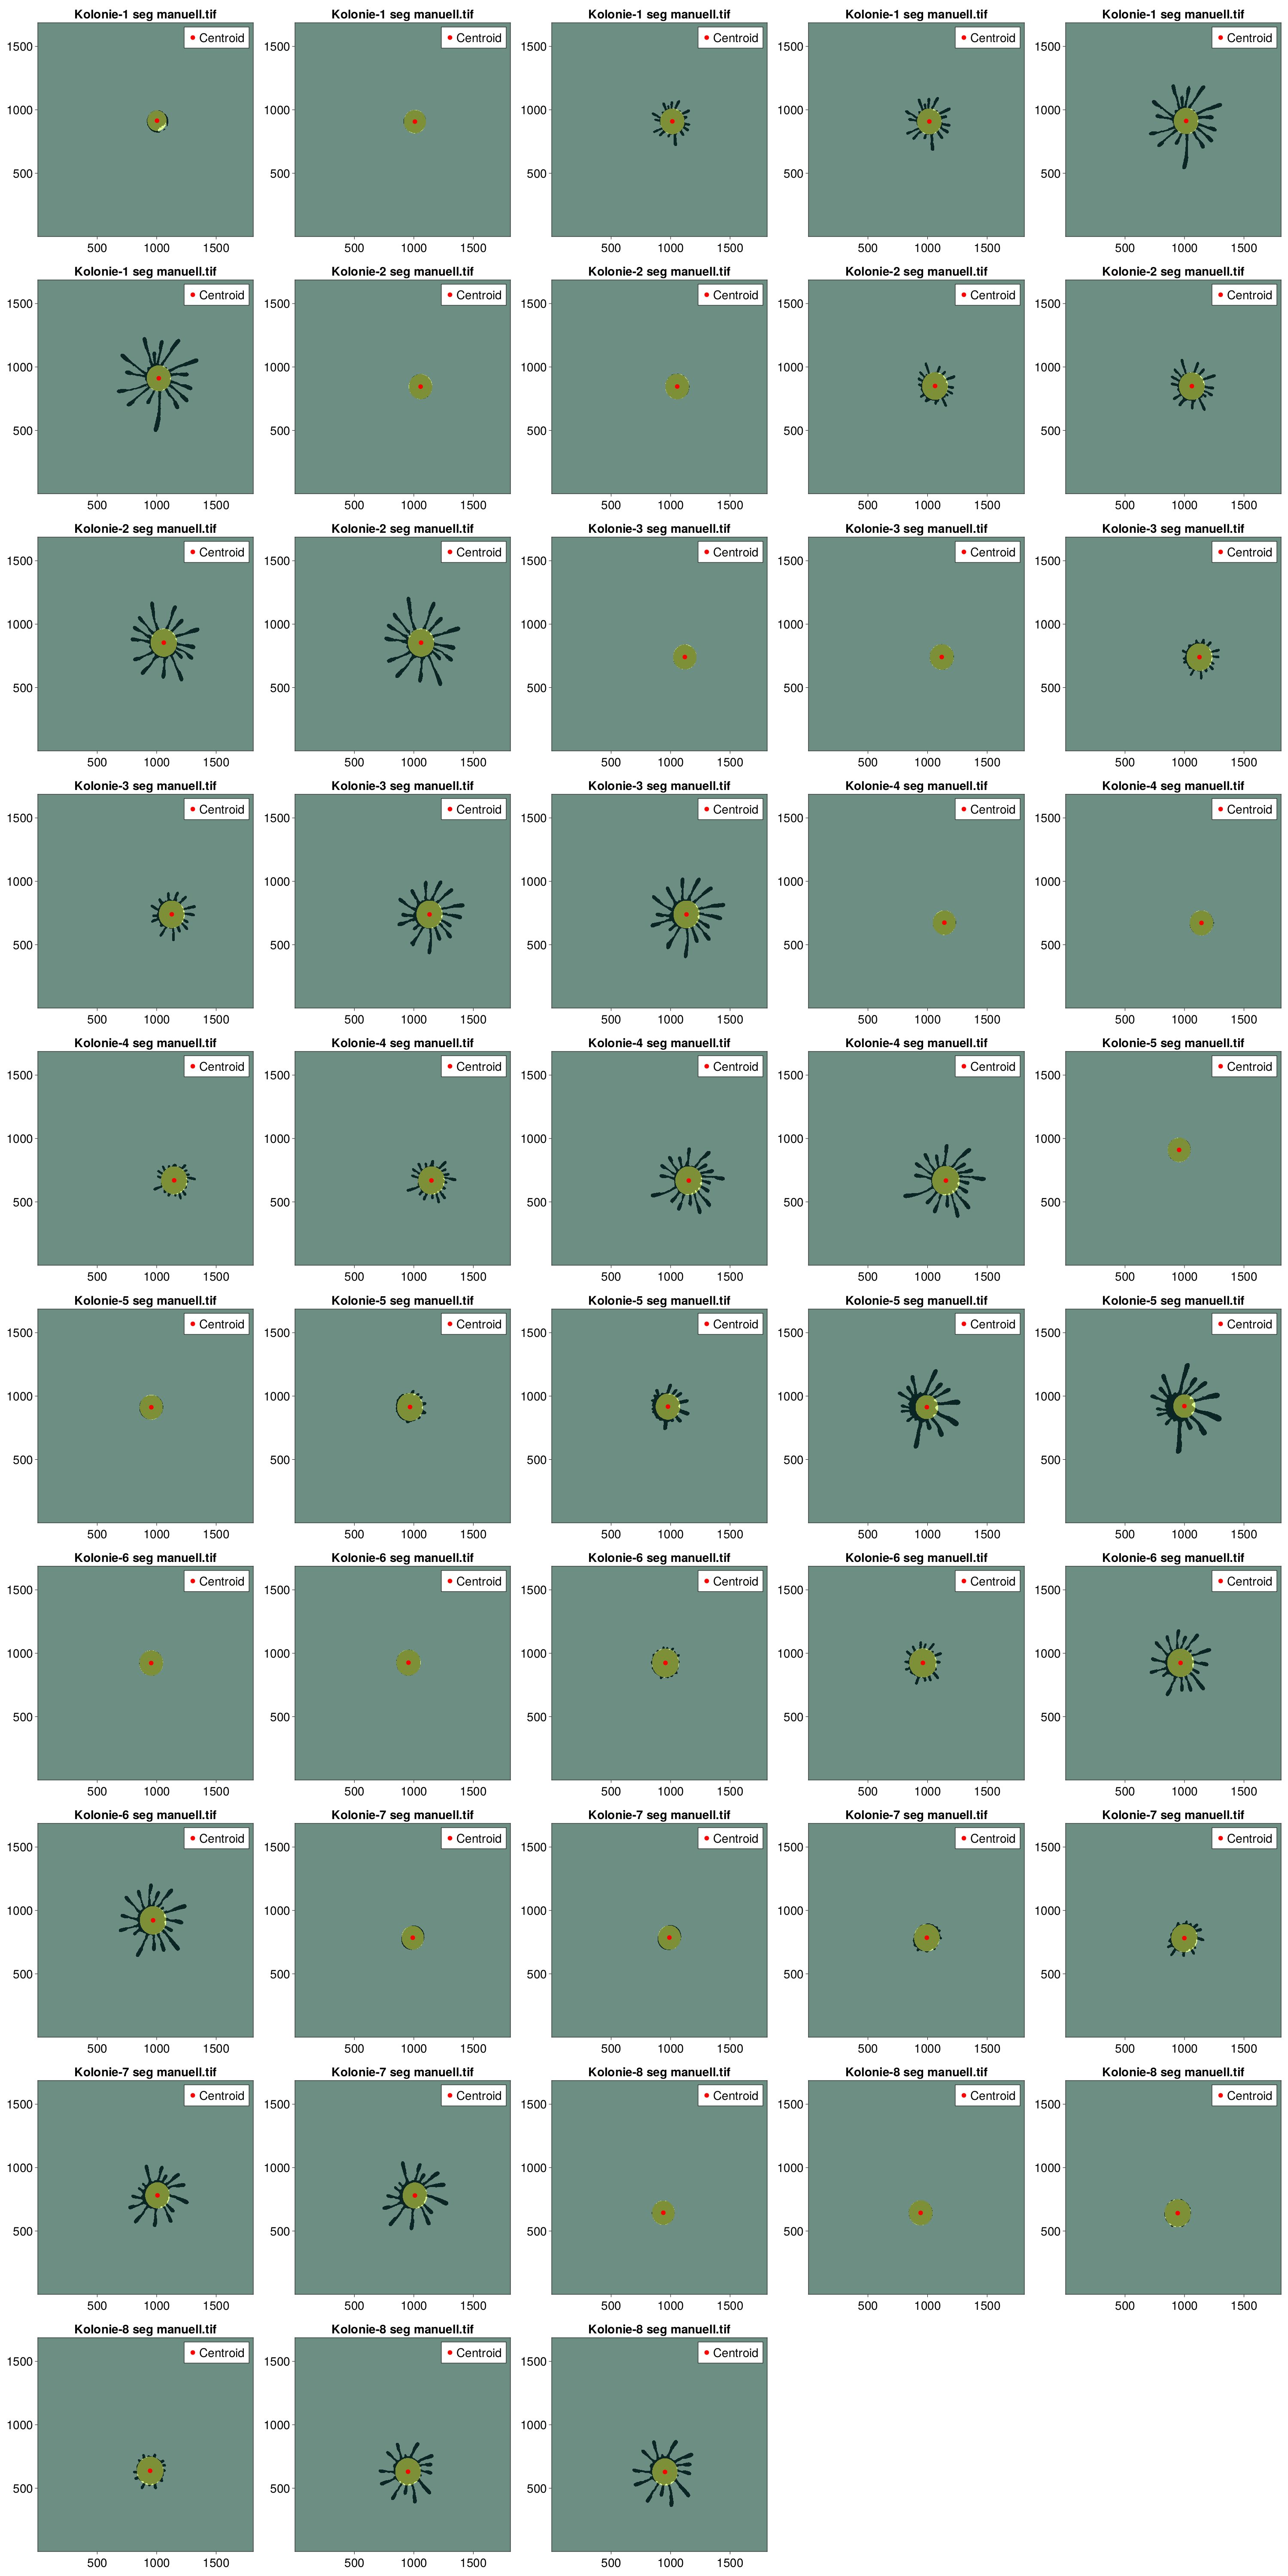

In [16]:
fig_big = Figure(resolution = res_scaling(img_int_vec, factor =3))

c = 0 
for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        y,x = centroid(int_img)
        ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1], title = colonies[i])
        #hidedecorations!(ax)
        circle_kernel = build_circle([y,x],int_img,Points,threshold = 0.8)
        heatmap!(ax,int_img,colormap = :algae)
        #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
        heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))
        #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
        
        scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
        #scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid convoluted")
        axislegend(ax)
        c += 1
            
    end

end

save(joinpath(path,"methos_compare_centroid.png"), fig_big)

fig_big

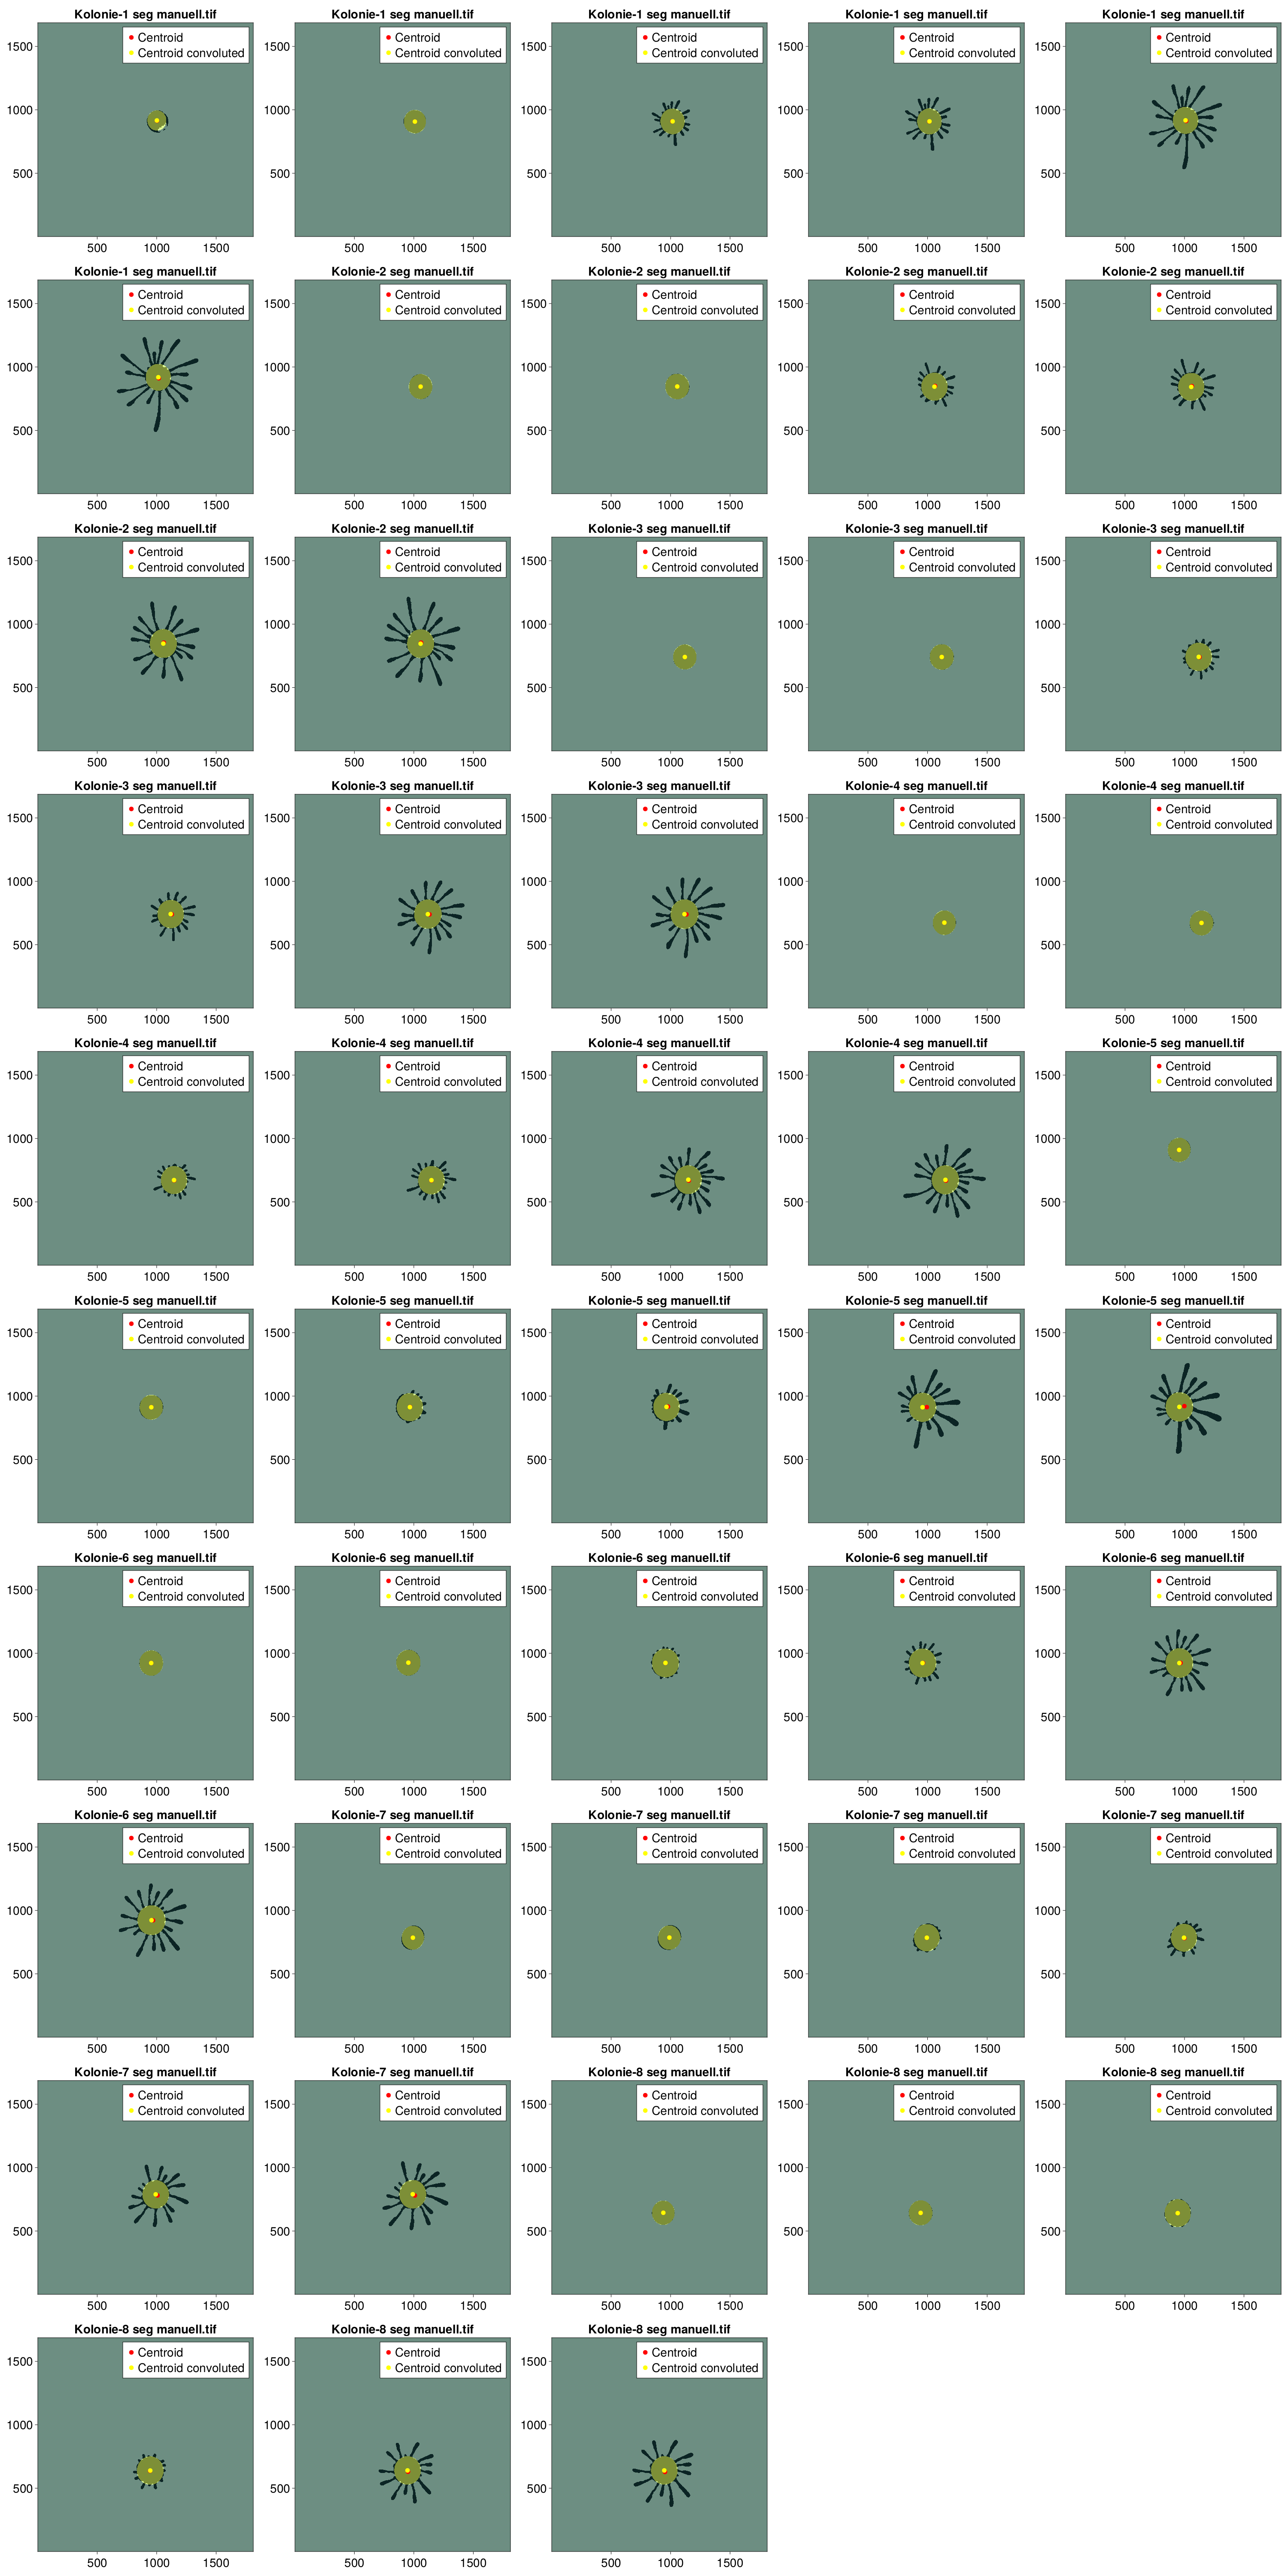

In [18]:
fig_big = Figure(resolution = res_scaling(img_int_vec, factor =3))

c = 0 
for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        y,x = centroid(int_img)
        ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1], title = colonies[i])
        #hidedecorations!(ax)
        circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
        heatmap!(ax,int_img,colormap = :algae)
        #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
        heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))
        #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
        
        scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
        scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid convoluted")
        axislegend(ax)
        c += 1
            
    end

end

save(joinpath(path,"methos_compare_cov.png"), fig_big)

fig_big


In [19]:
fig_89 = Figure(resolution =(2000,2000))
int_img = img_int_vec[7][:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)

int_img = img_int_vec[7][:,:,4]
out = conv( int_img, kernel ) ./ nneigh
y_c, x_c = centroid(out .> threshold_conv)

2-element Vector{Int64}:
 996
 785

In [19]:
#int_img = hcat(int_img[1:end-15,70:end],zeros(Int,750-15,20))

In [20]:
int_img = img_int_vec[2][:,:,6]
int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
typeof(int_img)

Matrix{Int64} (alias for Array{Int64, 2})

In [21]:
size(int_img)

(1794, 1641)

In [22]:
size(img_int_vec[2][:,:,6]) == size(img_int_vec[2][:,:,1])

true

In [23]:
int_fac = round(Int,(1-0.8705035971223022)*size(int_img)[1]/2)

116

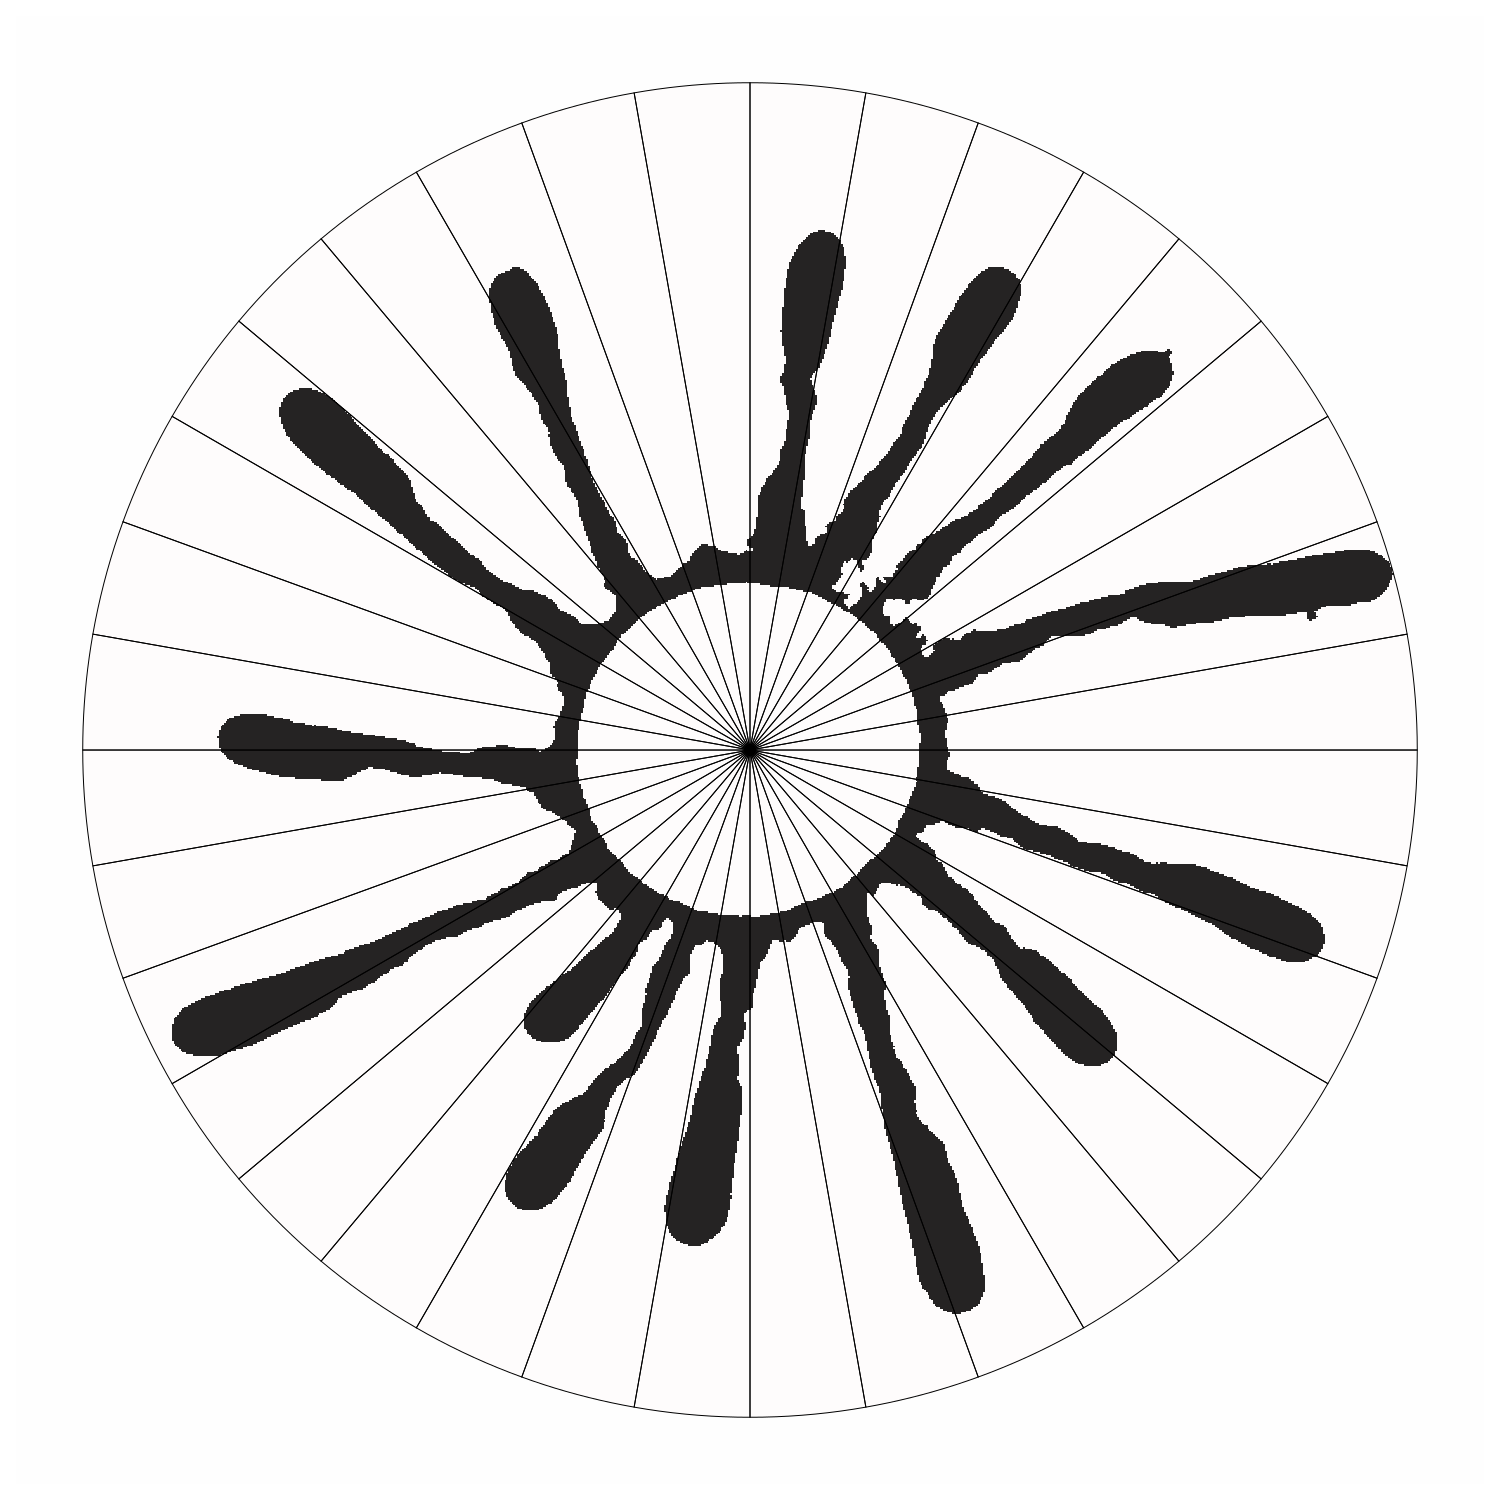

In [21]:
fig_89 = Figure(resolution =(1500,round(Int,1500)))
int_img = img_int_vec[7][:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)

int_img = img_int_vec[2][:,:,6]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img = rotr90(int_img)
x = 420
y_o = 150
x_o = -3


int_img = int_img[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]
int_fac = round(Int,(1-0.8705035971223022)*size(int_img)[1]/2)

int_img = int_img[:,int_fac: end-int_fac]
out = conv( int_img, kernel ) ./ nneigh
y_c, x_c = centroid(out .> threshold_conv)
y,x = centroid(int_img)
ax = CairoMakie.Axis(fig_89[1,1])
ax2 = CairoMakie.Axis(fig_89[1,1])
hidedecorations!(ax2)
hidedecorations!(ax)

hidespines!(ax)
hidespines!(ax2)

circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
#heatmap!(ax,int_img,colormap = (:hawaii,1.0))
#heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
#heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))

int_img_1 = img_int_vec[2][:,:,1]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img_1 = rotr90(int_img_1)
x = 420
y_o = 150
x_o = -3
int_img_1 = int_img_1[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]

int_fac = round(Int,(1-0.8705035971223022)*size(int_img_1)[1]/2)

int_img_1 = int_img_1[:,int_fac: end-int_fac]

#heatmap!(ax,int_img,colormap = (:grayC10,1.0))

heatmap!(ax,(int_img.-int_img_1).*-1,colormap = (:grayC10,1.0))
#heatmap!(ax,int_img_1, colormap  =(:thermal, 0.5))
#scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")

#scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
#scatter!(ax,y_c, x_c, color = :black, markersize = 45, label = "Centroid")
pie_data = [1 for i in 1:10:360]
pie!(ax2,pie_data,radius = 10, color = (:red, 0.01))
#axislegend(ax)
fig_89

In [26]:
fig_big = Figure(resolution = res_scaling(img_int_vec, factor =3))

c = 0 
for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        y,x = centroid(int_img)
        ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1], title = colonies[i])
        #hidedecorations!(ax)
        circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
        heatmap!(ax,int_img,colormap = :algae)
        #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
        heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))
        #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
        
        scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
        scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid convoluted")
        axislegend(ax)
        c += 1
            
    end

end

# This is the correct one below, don't kill it

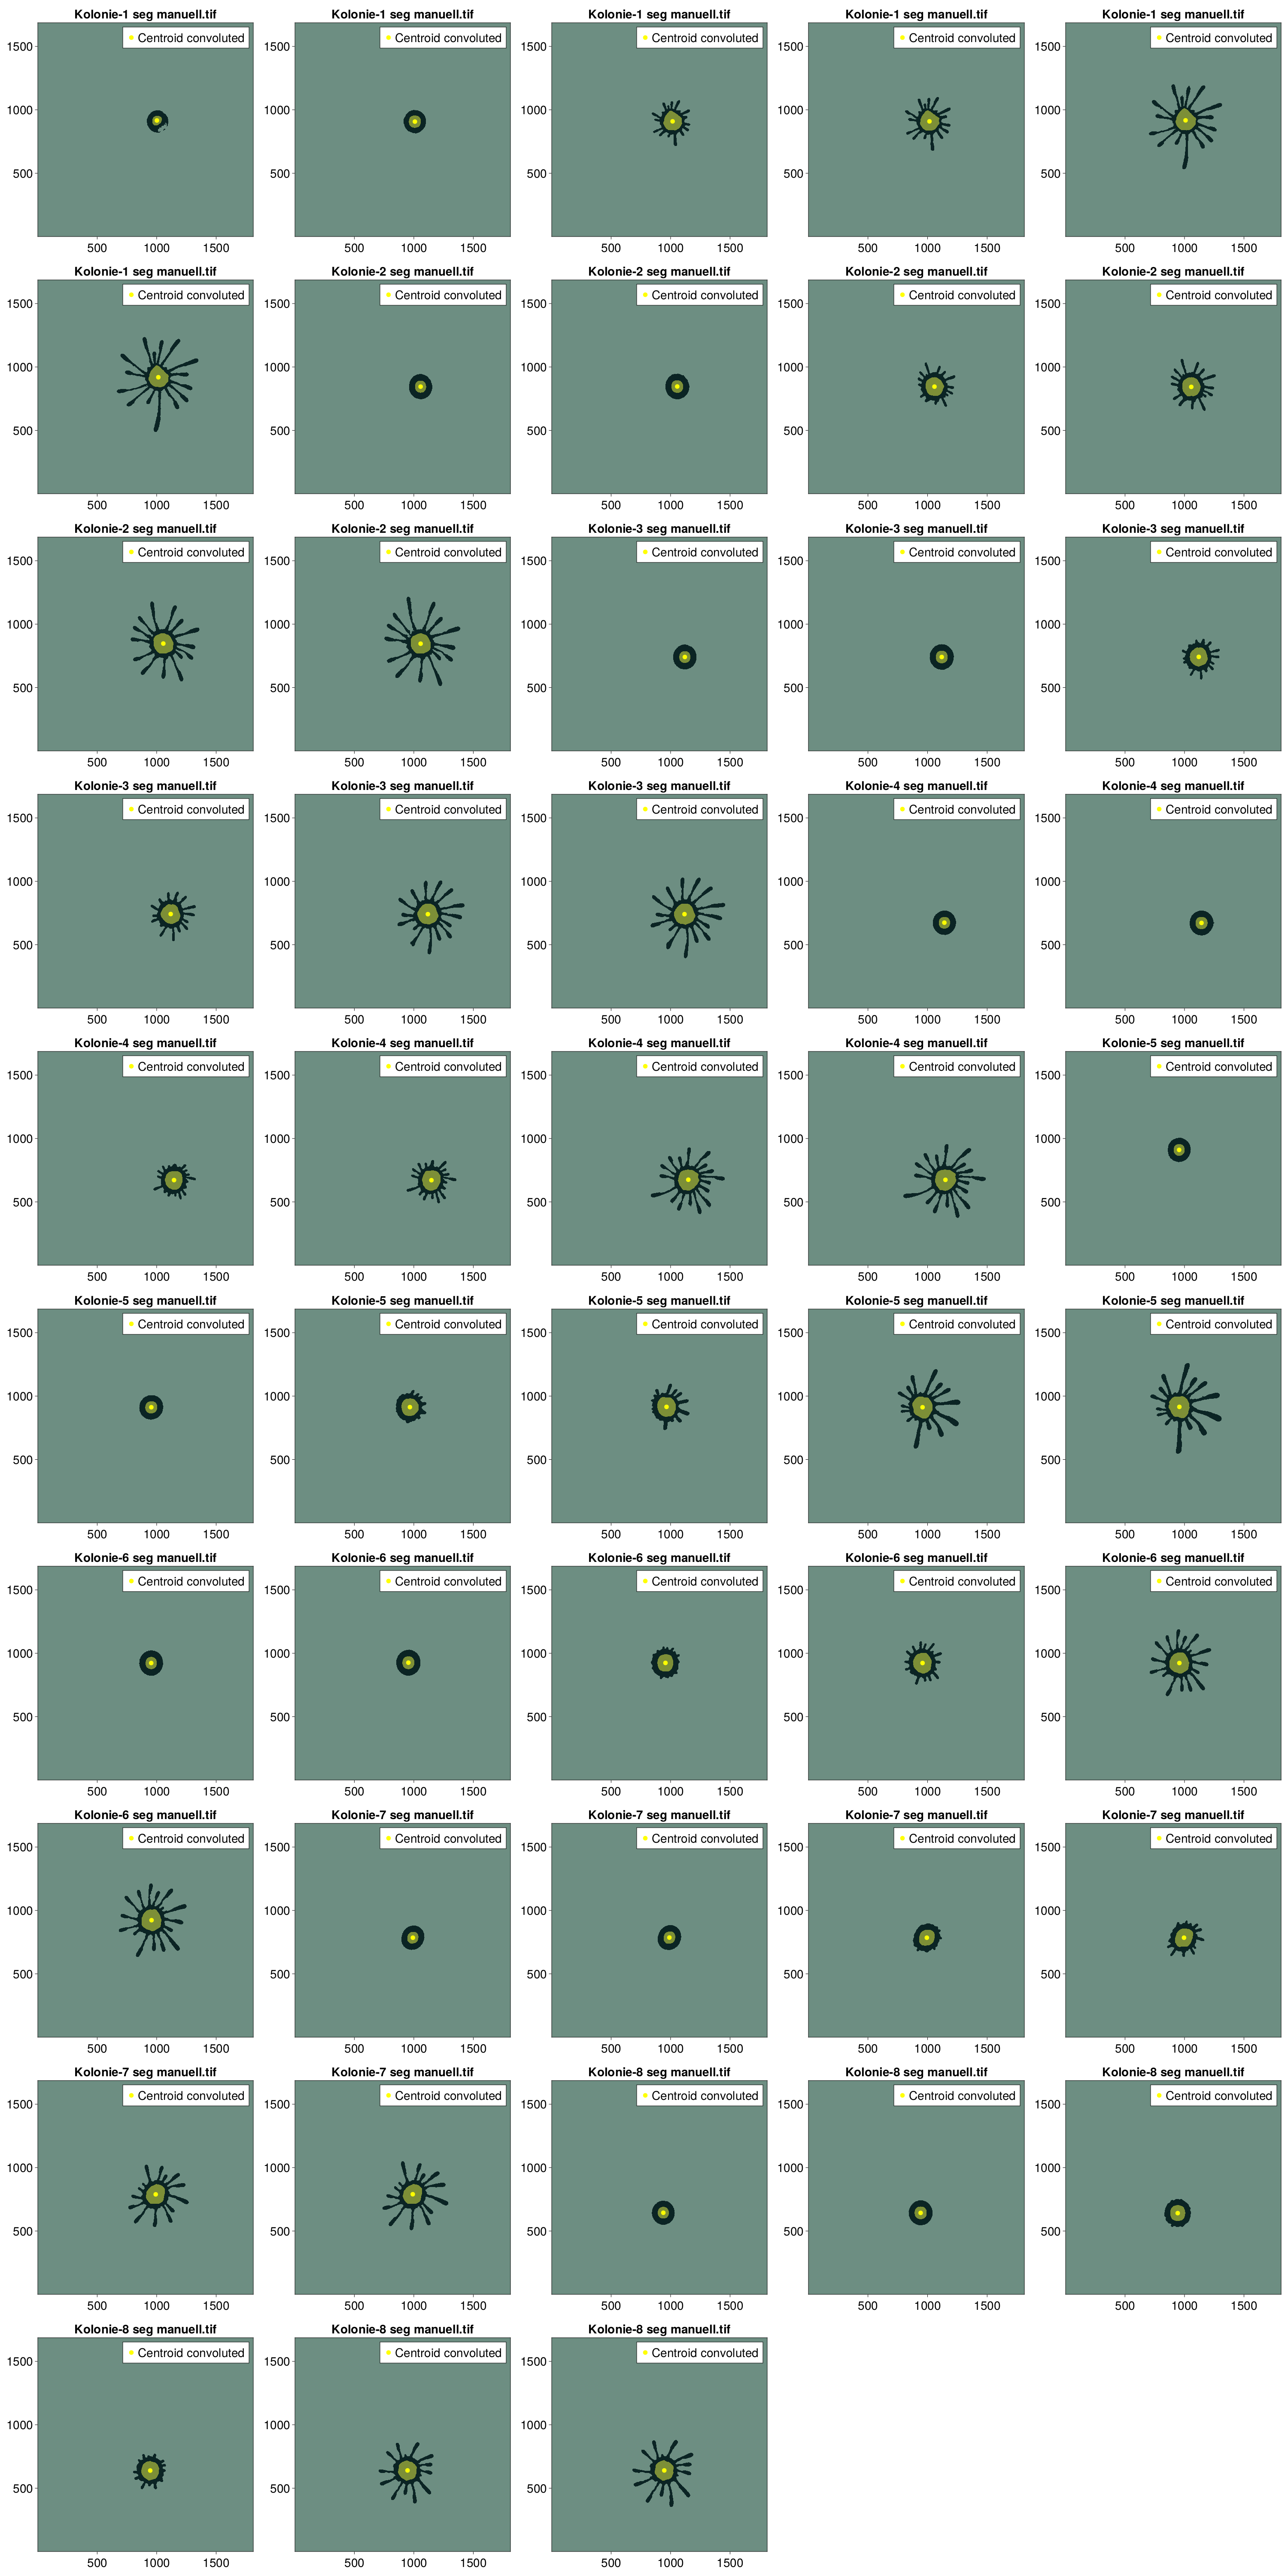

In [27]:
fig_big = Figure(resolution = res_scaling(img_int_vec, factor =3))

c = 0 
for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        y,x = centroid(int_img)
        ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1], title = colonies[i])
        #hidedecorations!(ax)
        heatmap!(ax,int_img,colormap = :algae)
        heatmap!(ax,out .> threshold_conv, colormap  =(:thermal, 0.5))
        #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
        
        #scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
        scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid convoluted")
        axislegend(ax)
        c += 1
            
    end

end

save(joinpath(path,"methos_compare_cov_shown.png"), fig_big)

fig_big

### Calculate the angular correlation function once with the convoluted centroid and fitted circle and second with the OG colone as mask 

In [28]:
a = 1
fig_big = Figure(resolution = res_scaling(img_int_vec, factor =3, plots = 2))
c = 0 

for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        ang_mec_og = angular_metric(int_img .- img_stack[:,:,1],[y1,x1], steps = steps_angular)
        pair_mec_og = pair_cor_metric2(z == 1 ? int_img : int_img .- img_stack[:,:,1],[y1,x1], steps = steps_angular,samples = samples_pair)
        
        fitted_circle = build_circle([y_c, x_c], int_img, Points, threshold = threshold_c)
        ang_mec_conv = angular_metric(z == 1 ? int_img : int_img .- fitted_circle , [y1,x1], steps = steps_angular )
        
        pair_mec_conv = pair_cor_metric3(z == 1 ? int_img : int_img.- fitted_circle, [y_c, x_c], steps = steps_angular,samples = samples_pair,counter_while = whily )
        
        ax = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3-2], title = colonies[i])
        heatmap!(ax,int_img,colormap = :algae)
        #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
        scatter!(ax,y1,x1, color = :blue, markersize = 10, label = "first centroid")
        scatter!(ax,y_c, x_c, color = :yellow, markersize = 10, label = "Convolut centroid")
        axislegend(ax)
        
        ax2 = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3-1], title = colonies[i])
        lines!(ax2,ang_mec_og, label = "OG angular metric" )
        
        ax3 = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3], title = colonies[i])
        lines!(ax3,pair_mec_og, label = "OG pair metric" )
        # convoluted angular metrix does not make sense for colony without expansion 
        if z != 1
            lines!(ax2,ang_mec_conv, label = "conv angular metric" )
            lines!(ax3,pair_mec_conv, label = "conv pair metric" )
        end
        axislegend(ax2)
        axislegend(ax3)
        push!(df,[data_set,colonies[i],time_points[z],ang_mec_og,ang_mec_conv,pair_mec_og,pair_mec_conv,sum(img_stack[:,:,1])])
        c += 1
             
    end

end

save(joinpath(path,"angular&pair.png"), fig_big)
fig_big


UndefVarError: UndefVarError: `angular_metric` not defined

#### Save data into .jls file to analyse further in seperate notebook

In [34]:
join(unique(df.data_set))

"10_04_23_stacked_half_res14_06_23_stacked_full_res14_06_23_stacked_half_res"

In [35]:
unique(df.data_set)

3-element Vector{String}:
 "10_04_23_stacked_half_res"
 "14_06_23_stacked_full_res"
 "14_06_23_stacked_half_res"

In [36]:
df

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,10_04_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[5617, 4627, 5315, 5201, 5811, 5913, 5244, 5330, 5585, 5490 … 5471, 5597, 5369, 5281, 5877, 5975, 5201, 5298, 4585, 4052]","[5742, 4696, 5277, 5768, 5796, 5360, 5545, 5576, 5796, 5293 … 5381, 5774, 5608, 5675, 5443, 5628, 5894, 5383, 4777, 6399]",2992
2,10_04_23_stacked_half_res,Kolonie 1.tif,24,"[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 4, 4, 1, 5, 1, 4, 5, 5]","[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]","[4758, 9601, 9648, 9441, 9256, 9013, 8816, 8428, 8316, 7973 … 5478, 5359, 5644, 5591, 5311, 5404, 5583, 5303, 5406, 2719]","[13719, 14151, 14297, 13761, 13485, 12699, 12309, 11702, 11239, 10458 … 6015, 5937, 5758, 5349, 5483, 5449, 5172, 5269, 5020, 5134]",2992
3,10_04_23_stacked_half_res,Kolonie 1.tif,48,"[0, 0, 5, 4, 1, 5, 1, 4, 3, 4 … 3, 5, 3, 4, 1, 5, 1, 4, 5, 5]","[0, 0, 1, 1, 0, 1, 1, 0, 1, 0 … 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]","[9299, 18384, 17718, 17472, 16455, 15434, 14579, 13180, 12039, 10923 … 6325, 6456, 6417, 6381, 6572, 6351, 6035, 6329, 6120, 3116]","[20816, 20616, 19806, 19053, 17864, 16766, 15134, 14095, 12597, 10982 … 6777, 6744, 6527, 6509, 6462, 6347, 6233, 6217, 6031, 6074]",2992
4,10_04_23_stacked_half_res,Kolonie 2.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 8, 6, 9, 7, 9, 7, 9, 10 … 7, 10, 9, 7, 9, 7, 10, 6, 9, 31]","[5408, 4592, 5212, 5138, 5876, 5801, 5240, 5278, 5538, 5527 … 5468, 5447, 5372, 5312, 5925, 5894, 5236, 5212, 4632, 3991]","[5753, 4838, 5410, 5688, 5648, 5534, 5523, 5589, 5933, 5351 … 5441, 5842, 5577, 5646, 5424, 5723, 5693, 5219, 4803, 6321]",3043
5,10_04_23_stacked_half_res,Kolonie 2.tif,24,"[0, 2, 8, 9, 6, 9, 9, 14, 15, 23 … 3, 5, 4, 6, 4, 7, 1, 7, 7, 9]","[0, 2, 0, 3, 4, 2, 5, 8, 11, 18 … 1, 1, 0, 0, 0, 0, 0, 1, 0, 2]","[4574, 8130, 8519, 8662, 8198, 7898, 7868, 7762, 7516, 7400 … 5266, 5321, 5635, 5367, 5436, 5318, 5649, 5584, 5366, 2996]","[12703, 13667, 13876, 13202, 12865, 12520, 12188, 11651, 11388, 10810 … 5002, 5070, 5229, 5196, 5193, 5269, 5350, 5385, 5485, 5293]",3043
6,10_04_23_stacked_half_res,Kolonie 2.tif,48,"[0, 2, 8, 9, 7, 10, 10, 16, 18, 26 … 3, 5, 4, 6, 4, 7, 2, 7, 7, 10]","[0, 1, 0, 2, 4, 3, 5, 9, 14, 20 … 2, 2, 0, 1, 1, 0, 0, 0, 0, 1]","[9384, 18730, 18028, 17285, 16686, 15579, 14493, 13447, 12409, 11413 … 4591, 4894, 4839, 4860, 4818, 4824, 4949, 4957, 4885, 2486]","[22333, 22315, 21684, 20455, 19344, 18068, 16402, 15238, 13855, 12209 … 4495, 4398, 4519, 4255, 4189, 4178, 4076, 4074, 3976, 3953]",3043
7,10_04_23_stacked_half_res,Kolonie 3.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 10, 6, 11, 8, 10, 9, 9, 12 … 7, 12, 9, 9, 10, 8, 10, 6, 9, 32]","[5129, 4687, 5279, 5314, 5725, 5933, 5243, 5411, 5625, 5298 … 5414, 5648, 5364, 5253, 5992, 5846, 5320, 5191, 4727, 3958]","[5699, 4878, 5479, 5779, 5719, 5260, 5500, 5805, 5654, 5245 … 5431, 5743, 5799, 5611, 5262, 5650, 5861, 5188, 5052, 6172]",3416
8,10_04_23_stacked_half_res,Kolonie 3.tif,24,"[0, 0, 6, 5, 0, 4, 0, 3, 2, 1 … 7, 8, 7, 9, 6, 8, 5, 10, 7, 10]","[0, 0, 0, 1, 0, 2, 2, 0, 2, 2 … 3, 4, 3, 5, 3, 2, 4, 4, 0, 4]","[4753, 7699, 8870, 8583, 8119, 8386, 7813, 7685, 7424, 7258 … 5022, 5107, 5176, 5248, 5198, 4879, 5412, 5209, 4744, 2842]","[13830, 14579, 14611, 13589, 13869, 13029, 12427, 11924, 11041, 10930 … 3153, 3347, 3310, 3157, 3425, 2980, 3320, 3197, 3117, 3311]",3416
9,10_04_23_stacked_half_res,Kolonie 3.tif,48,"[0, 0, 6, 5, 0, 3, 0, 3, 2, 1 … 32, 35, 35, 37, 36, 37, 36, 38, 36, 55]","[0, 1, 0, 1, 0, 3, 3, 1, 2, 2 … 27, 30, 31, 32, 32, 31, 34, 31, 29, 47]","[7935, 15717, 15240, 14875, 14109, 13341, 12425, 11718, 10793, 9757 … 3838, 3770, 3624, 3695, 3470, 3448, 3382, 3402, 3324, 1757]","[18895, 18691, 18108, 17276, 16050, 15168

In [14]:
serialize(joinpath("metrics","data_sets_"*"$(length(unique(df.data_set)))_$(today()).jls"),df)
CSV.write(joinpath("metrics","data_sets_"*"$(length(unique(df.data_set)))_$(today()).csv"),df)

"metrics\\data_sets_1_2023-07-24.csv"

In [28]:
joinpath("metrics","data_sets_"*"$(length(unique(df.data_set)))_$(today()).jls") 

"metrics\\data_sets_2_2023-07-18.jls"

In [229]:
today()

2023-06-19

In [ ]:


df

In [28]:
df_f = @transform(df,:fourier_conv = (fft.(:metric_cov)), :fourier_OG = (fft.(:metric_OG)))
df_f = @transform(df_f, :abs_cov = [abs.(x[2:steps_angular÷2]) for x in :fourier_conv], :abs_OG = [abs.(x[2:steps_angular÷2]) for x in :fourier_OG])
first(df_f)

Row,data_set,colony,time,metric_cov,metric_OG,fourier_conv,fourier_OG,abs_cov,abs_OG
,String,String,Int64,Array…,Array…,Array…,Array…,Array…,Array…
1,Daten vom 10-04-23 stacked,Kolonie 1.tif,1,"[0, 0, 9, 6, 10, 7, 10, 8, 9, 10 … 7, 10, 9, 8, 10, 7, 10, 6, 9, 31]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","ComplexF64[2992.0+0.0im, 41.8133+26.7751im, -3.96295+46.5738im, 10.071+10.0781im, -3.12124+5.36258im, 7.31263-5.47319im, 18.628+5.00988im, -16.3949+6.5821im, 22.3136-5.25125im, -5.63334-9.28405im … -0.0524877+4.39068im, -5.63334+9.28405im, 22.3136+5.25125im, -16.3949-6.5821im, 18.628-5.00988im, 7.31263+5.47319im, -3.12124-5.36258im, 10.071-10.0781im, -3.96295-46.5738im, 41.8133-26.7751im]","ComplexF64[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im … 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]","[49.6514, 46.7421, 14.2476, 6.20479, 9.13403, 19.2899, 17.6668, 22.9232, 10.8595, 4.391 … 65.1804, 49.1299, 67.5403, 53.2448, 55.1886, 63.6899, 219.952, 66.1522, 58.7147, 71.0192]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [29]:
cv_28 = @chain df_f begin
    @subset(:data_set .== "Daten vom 28-03-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:cv_OG = mean(std.(:metric_OG)./mean.(:metric_OG)), :cv_cov = mean(std.(:metric_cov)./mean.(:metric_cov))  )
    replace_nan.()
end

Row,time,data_stet,cv_OG,cv_cov
,Int64,String,Float64,Float64
1,1,Daten vom 28-03-23 stacked,0.0,0.134256
2,2,Daten vom 28-03-23 stacked,0.574617,0.262443
3,3,Daten vom 28-03-23 stacked,0.834173,0.569387
4,4,Daten vom 28-03-23 stacked,1.13032,0.908552


In [30]:
cv_23 = @chain df_f begin
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:cv_OG = mean(std.(:metric_OG)./mean.(:metric_OG)),:cv_cov = mean(std.(:metric_cov)./mean.(:metric_cov)) )
    replace_nan.()
end

Row,time,data_stet,cv_OG,cv_cov
,Int64,String,Float64,Float64
1,1,Daten vom 10-04-23 stacked,0.0,0.413521
2,2,Daten vom 10-04-23 stacked,0.847966,0.487472
3,3,Daten vom 10-04-23 stacked,1.41565,1.12411


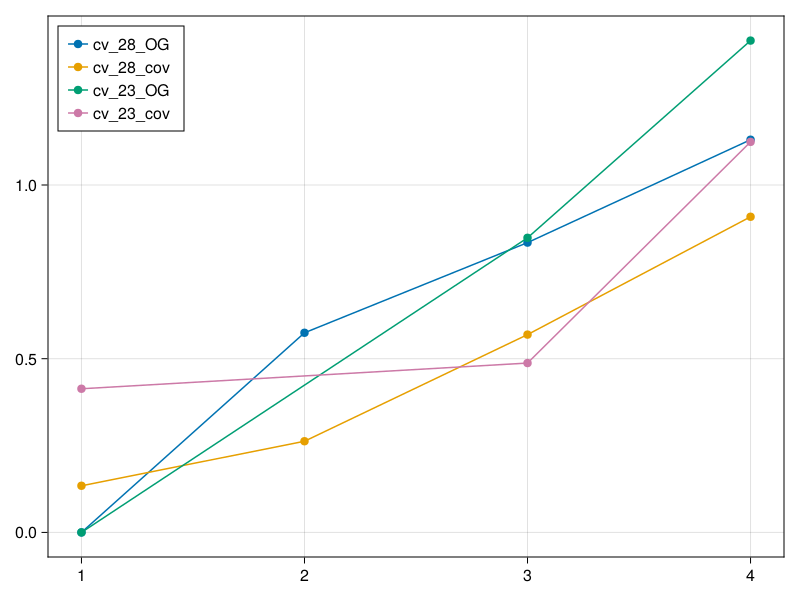

In [31]:
f2, ax, scatty = scatterlines(cv_28.:cv_OG, label ="cv_28_OG ")
scatterlines!(ax,cv_28.:cv_cov,label ="cv_28_cov")

scatterlines!(ax,[1,3,4],cv_23.:cv_OG,label ="cv_23_OG")
scatterlines!(ax,[1,3,4],cv_23.:cv_cov, label ="cv_23_cov")
axislegend(ax, position = :lt)
save("coeffient_of_variantion.png",f2)
f2

In [32]:
Index_fil_28 = @chain df_f begin 
    @subset(:data_set .== "Daten vom 28-03-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)) , :fil_cov = mean(sum.(:abs_cov)))
end
    

Row,time,data_stet,fil_OG,fil_cov
,Int64,String,Float64,Float64
1,1,Daten vom 28-03-23 stacked,0.0,18023.2
2,2,Daten vom 28-03-23 stacked,41856.3,52681.6
3,3,Daten vom 28-03-23 stacked,1.41813e5,1.50583e5
4,4,Daten vom 28-03-23 stacked,3.83837e5,3.89798e5


In [33]:
Index_fil_23 = @chain df_f begin 
    @subset(:data_set .== "Daten vom 10-04-23 stacked")
    groupby(:time)
    @combine(:data_stet = :data_set[1],:fil_OG = mean(sum.(:abs_OG)) , :fil_cov = mean(sum.(:abs_cov)))
end

Row,time,data_stet,fil_OG,fil_cov
,Int64,String,Float64,Float64
1,1,Daten vom 10-04-23 stacked,0.0,9281.05
2,2,Daten vom 10-04-23 stacked,13449.9,20389.2
3,3,Daten vom 10-04-23 stacked,78987.2,82690.1


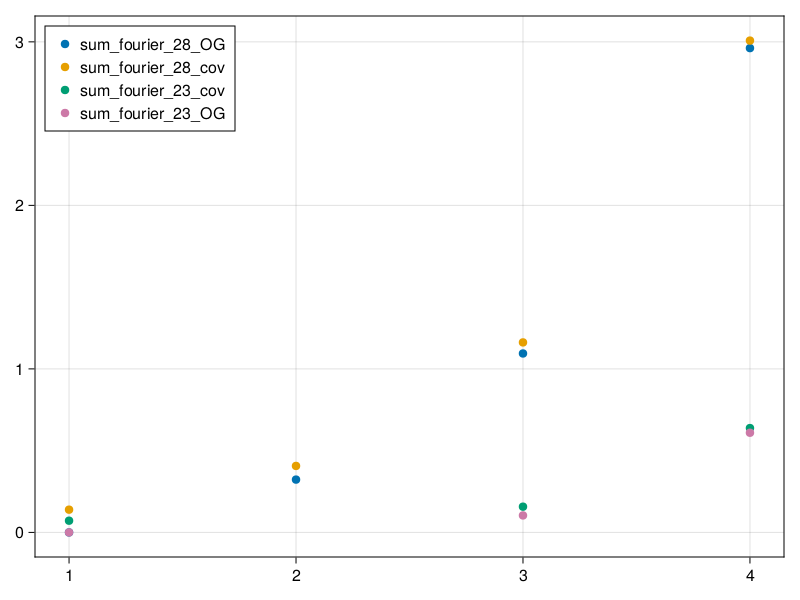

In [34]:
f = scatter(Index_fil_28.:fil_OG./(360^2), label = "sum_fourier_28_OG" )
scatter!(f.axis,Index_fil_28.:fil_cov./(360^2),label = "sum_fourier_28_cov")

scatter!(f.axis,[1,3,4],Index_fil_23.:fil_cov./(360^2),label = "sum_fourier_23_cov")
scatter!(f.axis,[1,3,4],Index_fil_23.:fil_OG./(360^2),label = "sum_fourier_23_OG")

axislegend(f.axis, position = :lt)
save("sum_fouriercoeffients.png",f)
f

In [35]:
filtered[3]

LoadError: UndefVarError: `filtered` not defined

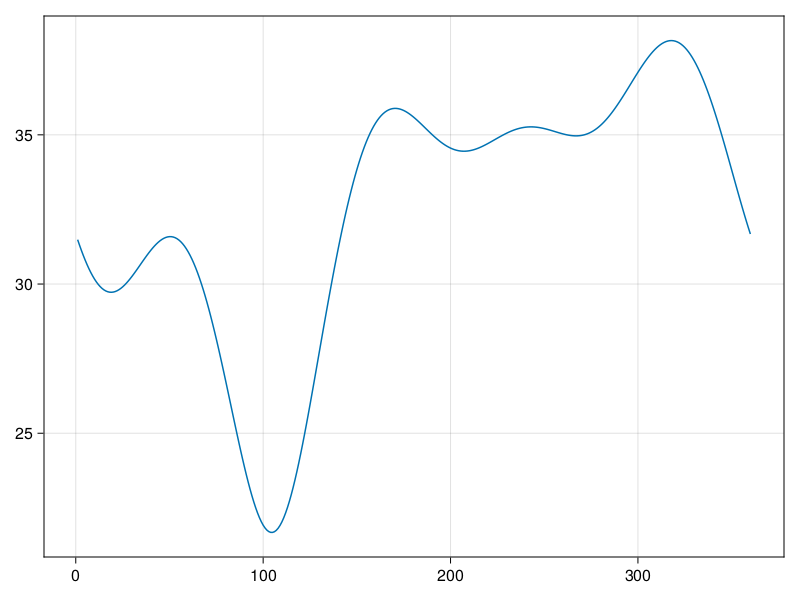

In [36]:
test_fil = filter_fourier_alpha.(df_f.fourier_OG, a = 5);
filtered = ifft.(test_fil)
lines(abs.(filtered[3]))

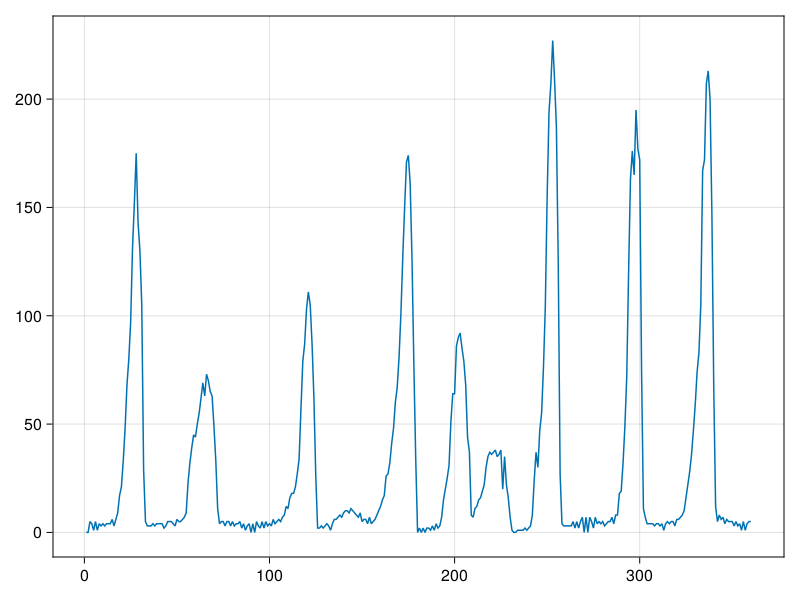

In [37]:
specturm = lines(df_f.metric_OG[3])

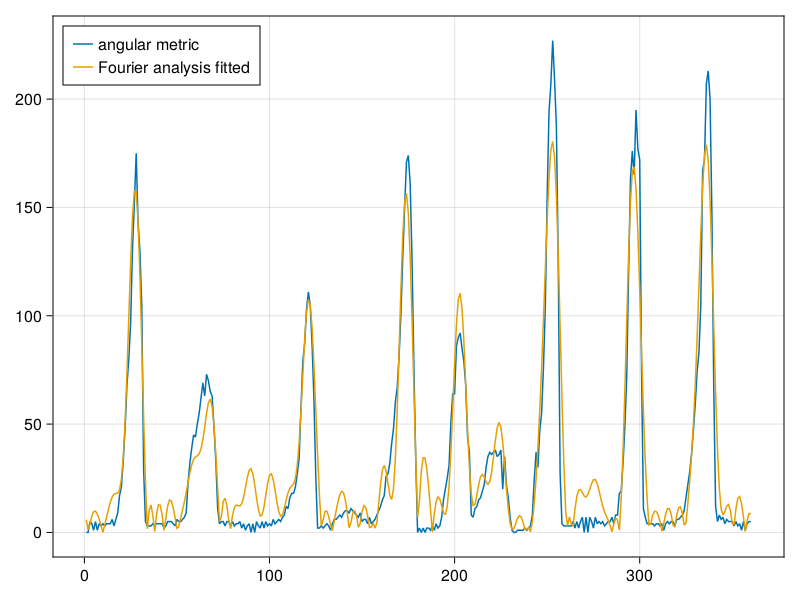

In [38]:
specturm = lines(df_f.metric_OG[3], label = "angular metric")
test_fil2 =  filter_fourier_beta.(df_f.fourier_OG, b = 0.1)
freq_vec = find_freq.(test_fil2)
filtered2 = ifft.(test_fil2)
lines!(specturm.axis,abs.(filtered2[3]),label = "Fourier analysis fitted")
axislegend(specturm.axis,position = :lt)
save("fitted_fourier_spectrum.png", specturm)
specturm

In [39]:
freq2 = Int[]
for i in freq_vec
    append!(freq2,i)
end
freq2

473-element Vector{Int64}:
  6
  9
 10
 14
 15
  2
  6
  8
  9
 10
 12
 13
 14
  ⋮
  6
  7
  8
 11
 13
 15
 16
 18
 19
 21
 27
 28

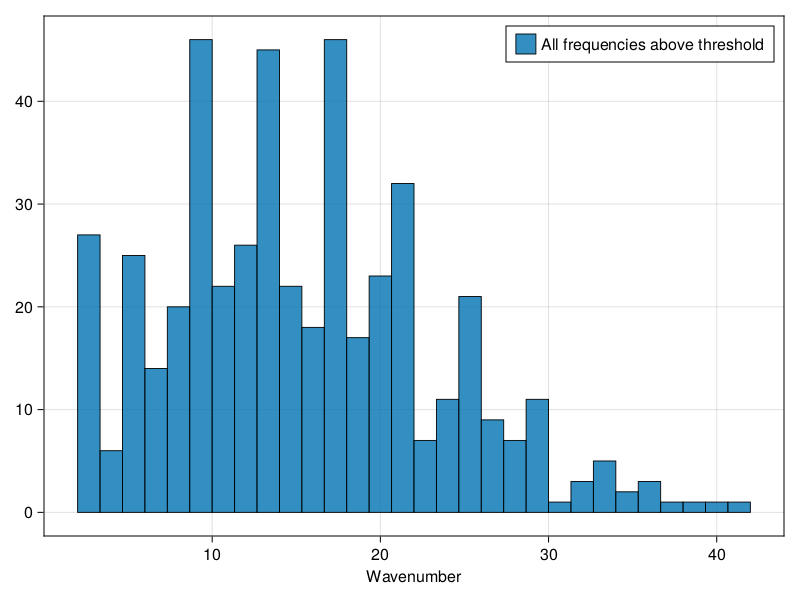

In [68]:
histi = hist(freq2, bins = 30,strokewidth = 0.9,label = "All frequencies above threshold")
#histi.axis
axislegend(histi.axis)
histi.axis.xlabel =  "Wavenumber"
save("histogramm of frequencies.png", histi)
histi

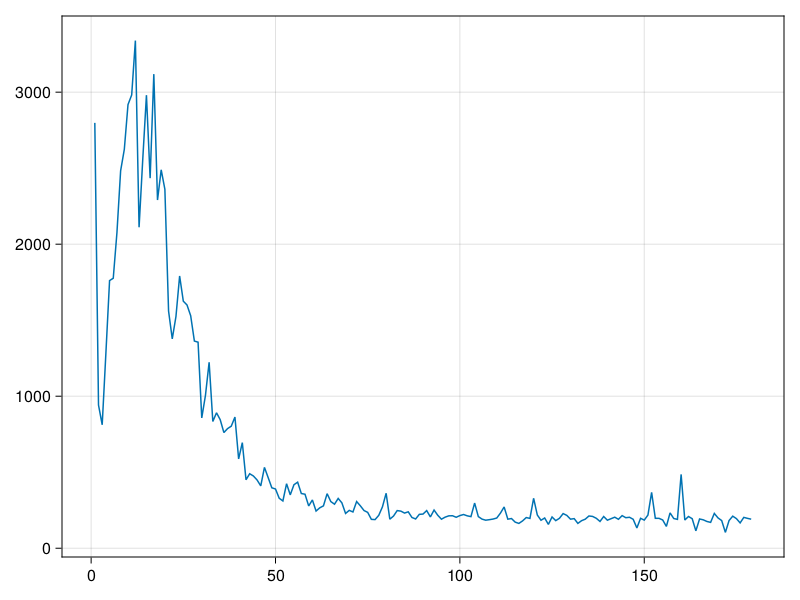

In [43]:
lines(mean(df_f.abs_cov))

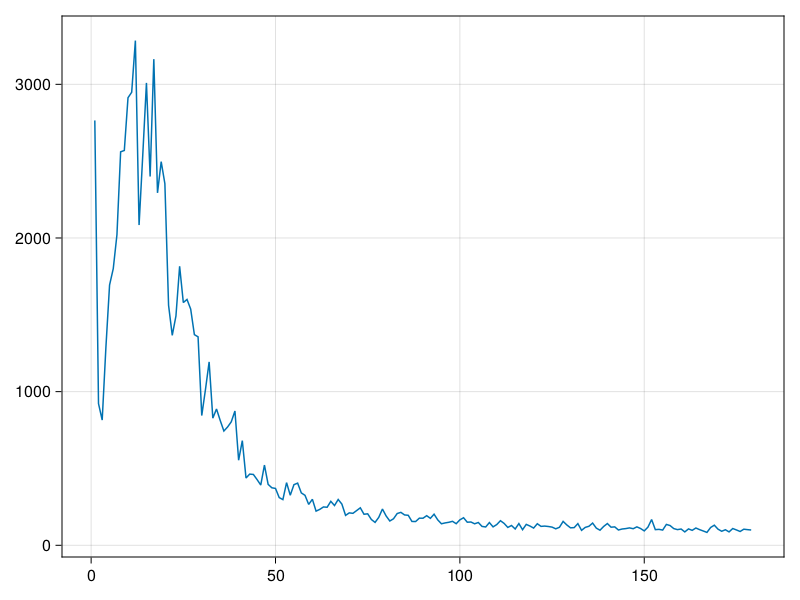

In [146]:
lines(mean(df_f.abs_OG))

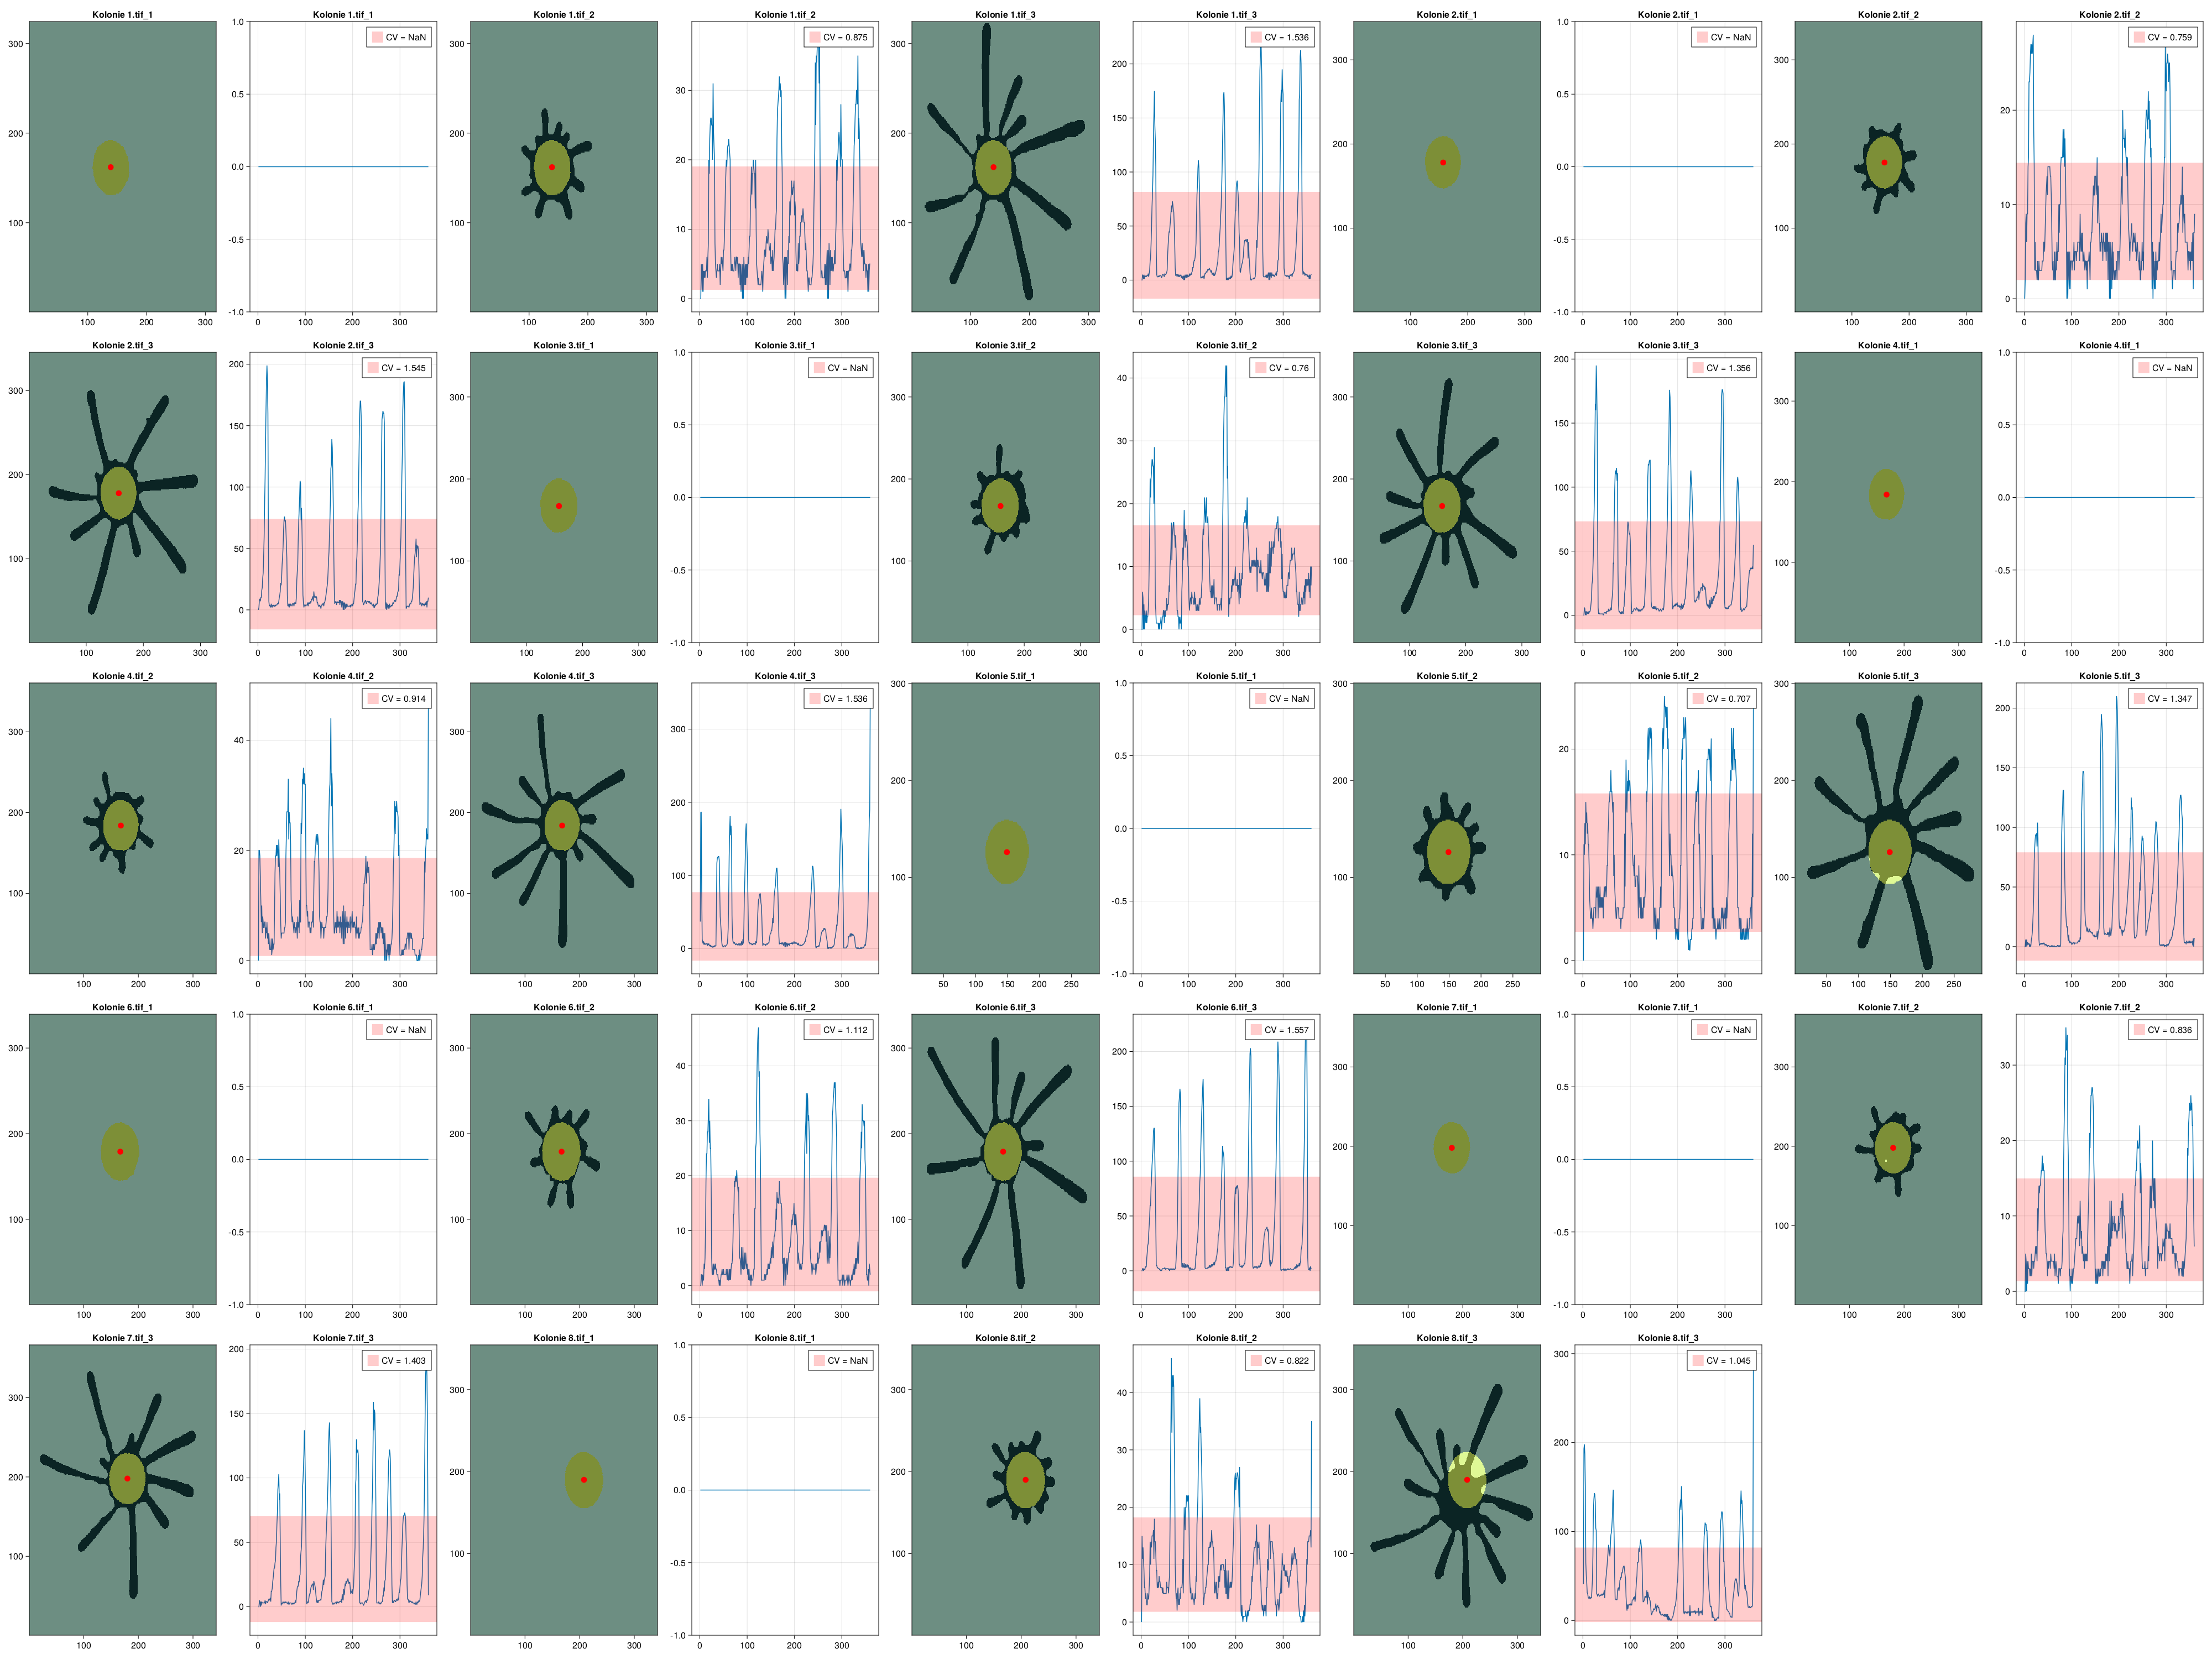

In [150]:
fig_big_stacked = Figure(resolution = (4000,3000))
c =0
ang_vec_vec_mask = Vector{Vector{Int64}}(undef,0)
cv_vec = Float64[]

for (i,img_stack) in enumerate(img_vec_2)
    mask = b_w_i.(img_stack[:,:,1])
    y,x = centroid(mask)
    for j in 1:size(img_stack)[3]
        img = b_w_i.(img_stack[:,:,j])
        ax = CairoMakie.Axis(fig_big_stacked[(c)÷5+1,(c%5+1)*2-1], title = "$(readdir(path_2)[i])_$j")
        heatmap!(ax,img, colormap = :algae )
        #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
        heatmap!(ax,mask,colormap =(:thermal,0.5))
        scatter!(ax, y,x, color = :red, markersize = 15)
        
        ax2 = CairoMakie.Axis(fig_big_stacked[(c)÷5+1,(c%5+1)*2], title = "$(readdir(path_2)[i])_$j")
        ang_vec = angular_metric((img.-mask),[y,x],steps = 360)
        push!(ang_vec_vec_mask, ang_vec)
        lines!(ax2, [x for x in 1:length(ang_vec)],ang_vec)
        hspan!(ax2, mean(ang_vec)-std(ang_vec),mean(ang_vec)+std(ang_vec), label = "CV = $(round(std(ang_vec)/mean(ang_vec),digits = 3 ))", color = (:red, 0.2))
        axislegend(ax2)
        push!(cv_vec,std(ang_vec)/mean(ang_vec))
        
        
        c += 1
    end
end

save("metric_stacked_cv.png",fig_big_stacked)
fig_big_stacked         

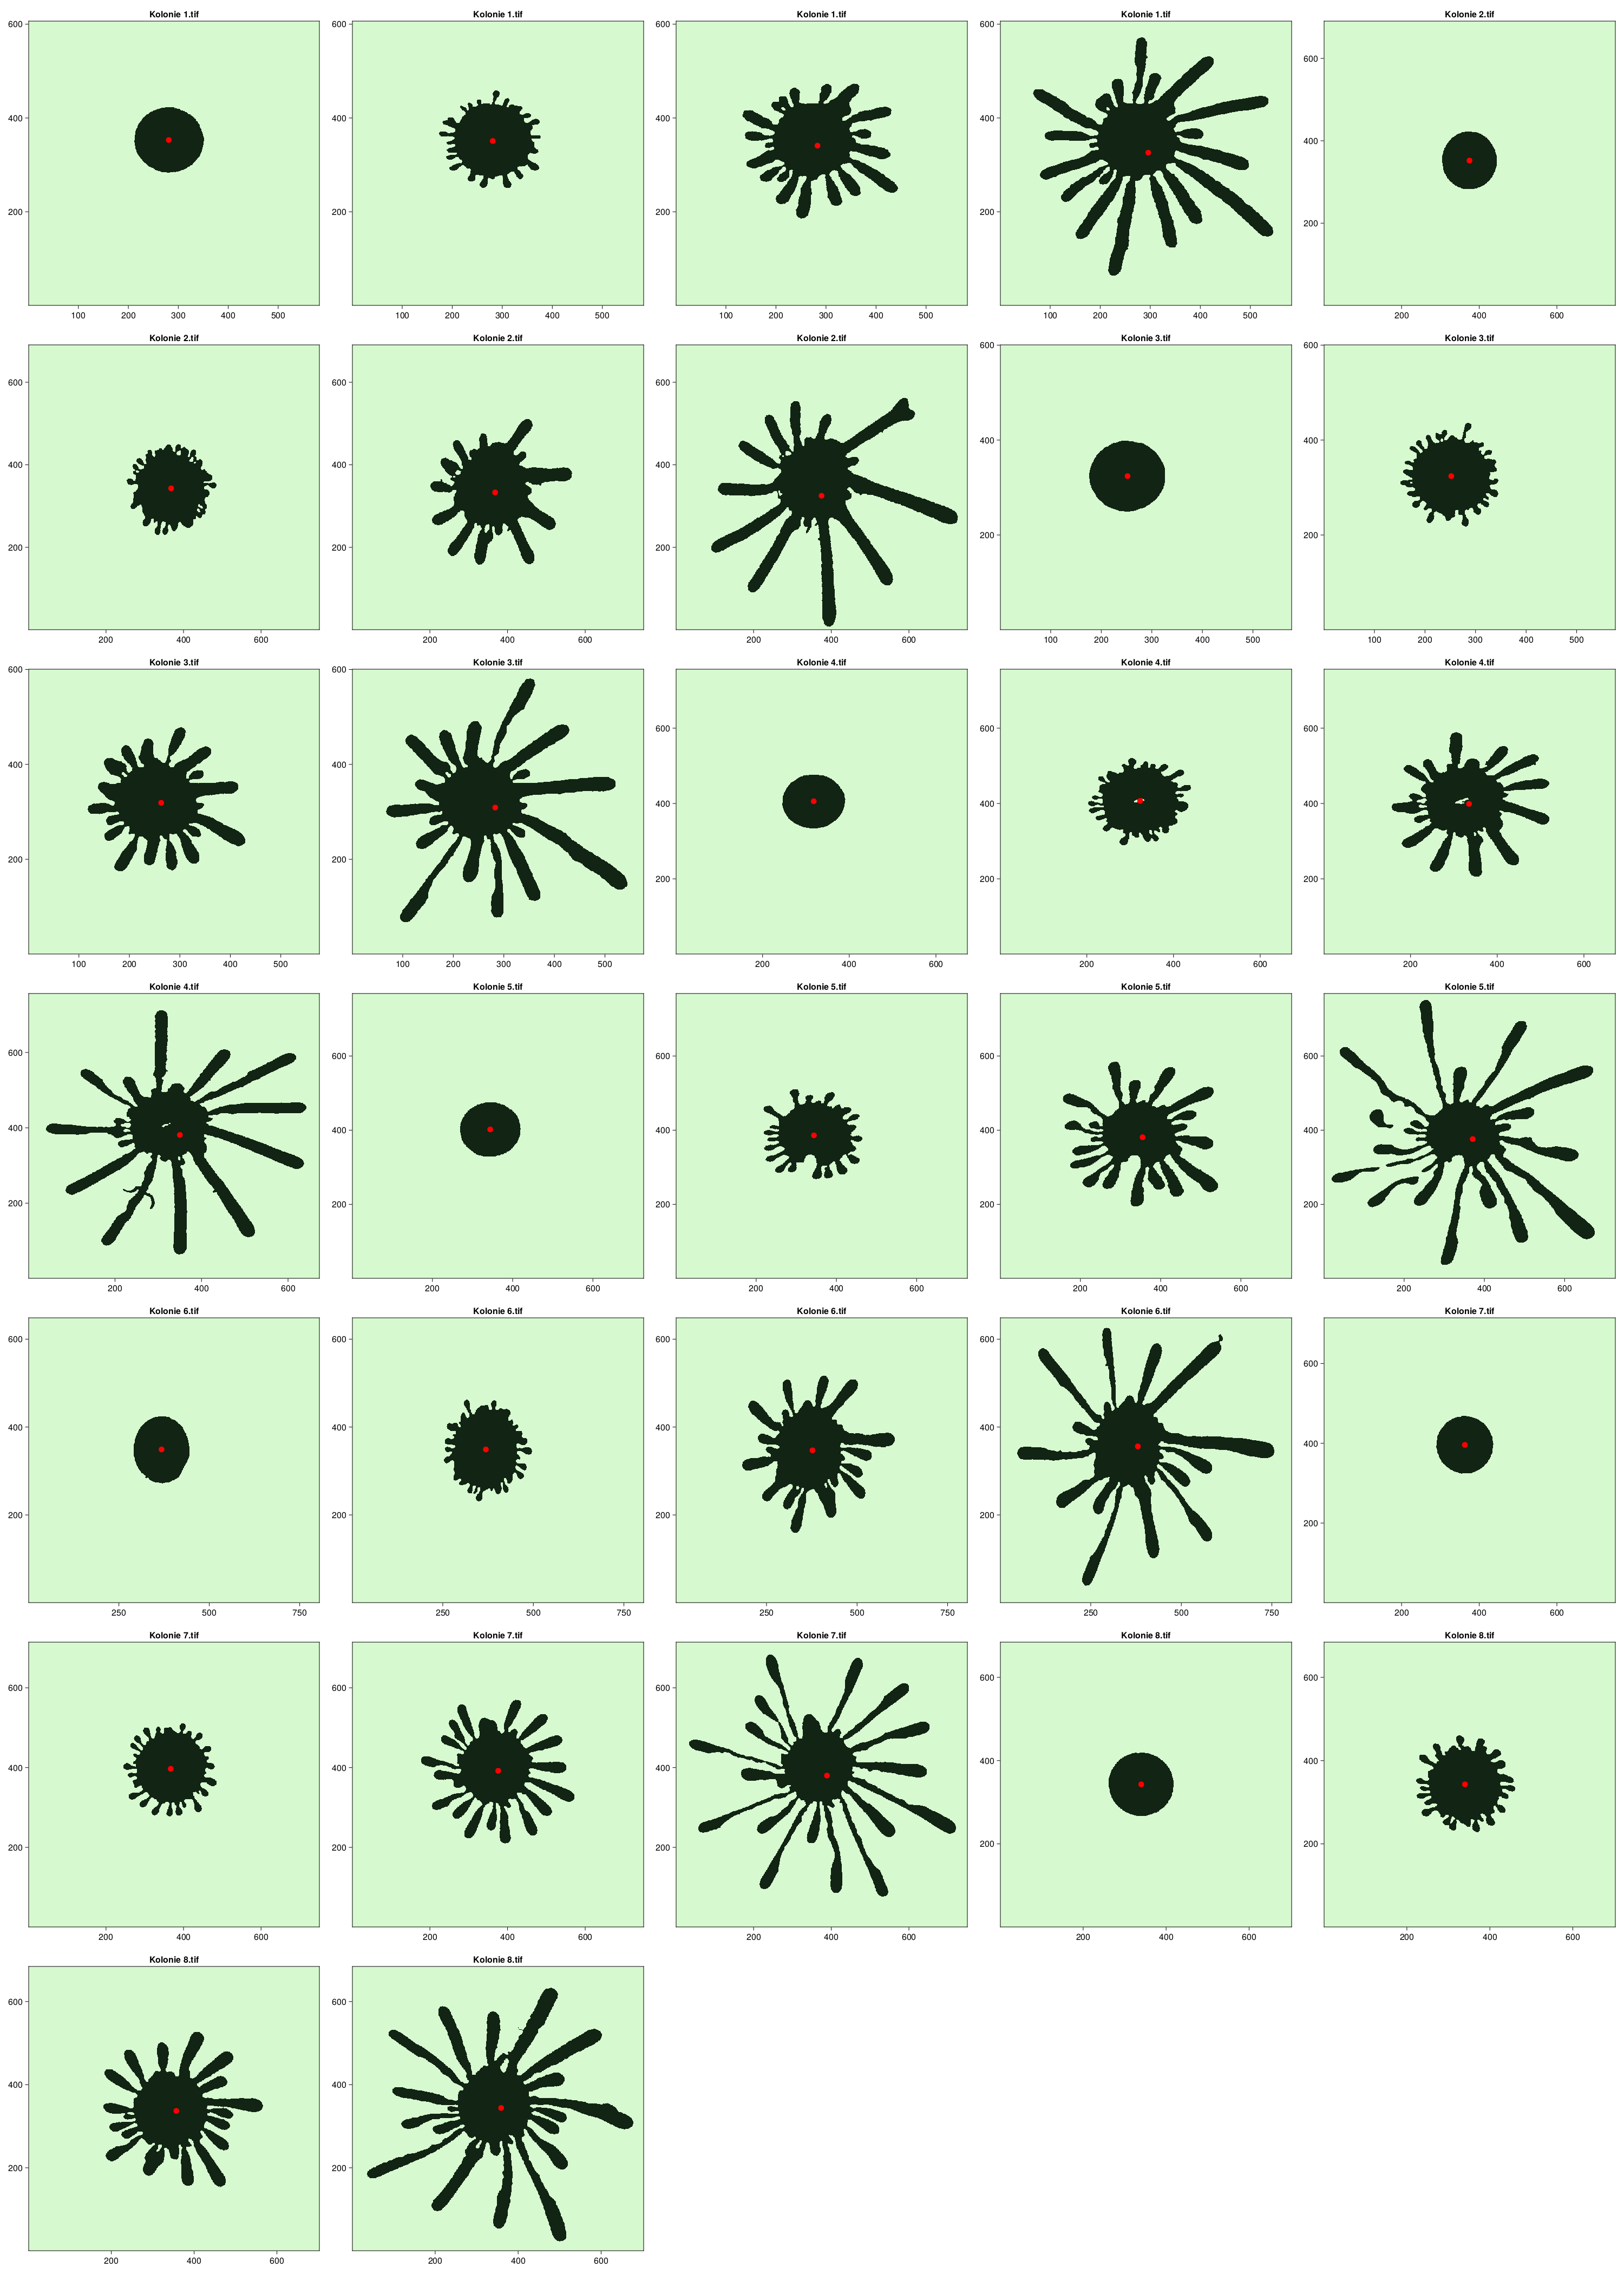

In [87]:
fig_big = Figure(resolution = res_scaling(img_int_vec))
c = 0 
for (i,img_stack) in enumerate(img_int_vec)

    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        y,x = centroid(int_img)
        ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1], title = readdir(path)[i])
        #hidedecorations!(ax)
        heatmap!(ax,int_img, colormap = :algae)
        scatter!(ax,y,x, color = :red, markersize = 15)
        c += 1
            
    end

end
#save("centroid_without_gaus.png", fig_big)
fig_big  

In [88]:
fig_big2 = Figure(resaolution = (3000,4000))
for (i,int_img) in enumerate(img_int_vec)
    y,x = centroid(int_img)
    Points = lattice_points(minimum(size(int_img))÷2)
    circle_kernel = build_circle([y,x],int_img,Points,threshold = 0.8)
    ax = CairoMakie.Axis(fig_big2[(i-1)÷5,i%5], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img,colormap =:algae)
    heatmap!(ax, circle_kernel, colormap = (:thermal, 0.5))
    scatter!(ax,y,x, color = :red, markersize = 15)
end
#save("centroid_without_gaus_centroid.png", fig_big2)
fig_big2

LoadError: BoundsError: attempt to access 582×606×4 BitArray{3} at index [1, 1]

### Its ok but not perfect

### Do the same with FFTW

In [29]:
rad = 50

kernel = create_kernel(rad, geometry = "circle")
nneigh = sum(  kernel )
    
out = conv( img_int_vec[32], kernel ) ./ nneigh;


LoadError: BoundsError: attempt to access 8-element Vector{BitArray{3}} at index [32]

In [30]:
comp_conv = Figure(resolution = (1600,500))
ax_1 = CairoMakie.Axis(comp_conv[1,1], title = "Original")
heatmap!(ax_1, img_int_vec[32])
ax_2 = CairoMakie.Axis(comp_conv[1,2], title = "Kernel")
heatmap!(ax_2, kernel)
ax_3 = CairoMakie.Axis(comp_conv[1,3], title = "Convolution")
heatmap!(ax_3, out)

comp_conv

LoadError: BoundsError: attempt to access 8-element Vector{BitArray{3}} at index [32]

In [31]:
rad = 50

kernel = create_kernel(rad, geometry = "square")
nneigh = sum(  kernel )
    
out = conv( img_int_vec[32], kernel ) ./ nneigh;


LoadError: BoundsError: attempt to access 8-element Vector{BitArray{3}} at index [32]

In [32]:
comp_conv = Figure(resolution = (1600,500))
ax_1 = CairoMakie.Axis(comp_conv[1,1], title = "Original")
heatmap!(ax_1, img_int_vec[32])
ax_2 = CairoMakie.Axis(comp_conv[1,2], title = "Kernel")
heatmap!(ax_2, kernel)
ax_3 = CairoMakie.Axis(comp_conv[1,3], title = "Convolution")
heatmap!(ax_3, out)

comp_conv

LoadError: BoundsError: attempt to access 8-element Vector{BitArray{3}} at index [32]

In [33]:
threshold = 0.95
y,x = centroid(img_int_vec[32])
y_c, x_c = centroid(out .> threshold)
y_c1,x_c1 = centroid(out)

h = heatmap( img_int_vec[32], colormap = :algae)
heatmap!(h.axis,out .> threshold, colormap = (:thermal, 0.5) )
#heatmap!(h.axis, int_img, colormap = (:thermal, 0.5))
scatter!(h.axis, y_c,x_c)
scatter!(h.axis,y,x, color = :red)
scatter!(h.axis, y_c1, x_c1, color = :green)
h

LoadError: BoundsError: attempt to access 8-element Vector{BitArray{3}} at index [32]

In [34]:
rad = 40
threshold = 0.9
kernel = create_kernel(rad)
nneigh = sum(kernel)
kernel_s = create_kernel(rad, geometry = "square")
nneigh_s = sum(kernel_s)


fig_big_cov = Figure(resolution = (3000,4000))

for (i,int_img) in enumerate(img_int_vec)
    out = conv( int_img, kernel ) ./ nneigh
    out_s = conv(int_img, kernel_s)./nneigh_s
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    y_c_s, x_c_s = centroid(round.(Int, out_s.>threshold))
    
    ax = CairoMakie.Axis(fig_big_cov[(i-1) ÷ 5,i%5], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax, out_s .> threshold, colormap =(:blues, 0.5))
    
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
    scatter!(ax, y_c_s, x_c_s, markersize = 15, color = :pink)
end
fig_big_cov

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [35]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad)
nneigh = sum(kernel)

fig_big_cov_c = Figure(resolution = (3000,4000))

for (i,int_img) in enumerate(img_int_vec)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    ax = CairoMakie.Axis(fig_big_cov_c[(i-1)÷5,i%5], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
end
save("centroid_without_gaus_circle_kernel.png", fig_big_cov_c)

fig_big_cov_c

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [36]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad, geometry = "square")
nneigh = sum(kernel)

fig_big_cov_s = Figure(resolution = (3000,4000))

for (i,int_img) in enumerate(img_int_vec)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    ax = CairoMakie.Axis(fig_big_cov_s[(i-1)÷5,i%5], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
end
save("centroid_without_gaus_square_kernel.png", fig_big_cov_s)

fig_big_cov_s

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [37]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad, geometry = "square")
nneigh = sum(kernel)

fig_big_cov_s_f = Figure(resolution = (3000,4000))
img_int_vec_filled = fill_holes.(img_int_vec,[(0.1,1000) for x in length(img_int_vec)])


for (i,int_img) in enumerate(img_int_vec_filled)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    ax = CairoMakie.Axis(fig_big_cov_s_f[(i-1)÷5,i%5], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
end
save("centroid_without_gaus_square_kernel_filled.png", fig_big_cov_s_f)

fig_big_cov_s_f

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [38]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad, geometry = "square")
nneigh = sum(kernel)

fig_small = Figure(resolution = (1000,500))
img_int_vec_filled = fill_holes.(img_int_vec,[(0.1,1000) for x in length(img_int_vec)])

int_img  = img_int_vec_filled[end]
out = conv( int_img, kernel ) ./ nneigh
y_c,x_c = centroid(round.(Int,out.>threshold))
ax1 = CairoMakie.Axis(fig_small[1,1], title =  readdir(path)[end])
circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
heatmap!(ax1,int_img, colormap = :algae )
#heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
heatmap!(ax1,circle,colormap =(:thermal,0.5))
scatter!(ax1, y_c, x_c, markersize = 15)

ax2 = CairoMakie.Axis(fig_small[1,2], title =  "ang_metric")
ang_vec = angular_metric((int_img.-circle),[y_c,x_c])
lines!(ax2, [x for x in 1:length(ang_vec)],ang_vec)
fig_small

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [39]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad, geometry = "square")
nneigh = sum(kernel)

fig_big_cov_s_f_m = Figure(resolution = (4000,3000))
img_int_vec_filled = fill_holes.(img_int_vec,[(0.1,1000) for x in length(img_int_vec)])

ang_vec_vec_conv = Vector{Vector{Int64}}(undef,0)
cv_vec = Float64[]
c = 0 
for (i,int_img) in enumerate(img_int_vec_filled)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    ax = CairoMakie.Axis(fig_big_cov_s_f_m[(c)÷5+1,(c%5)*2-1], title = readdir(path)[i])
    ax2 = CairoMakie.Axis(fig_big_cov_s_f_m[(c)÷5+1,(c%5)*2], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
    
  
    ang_vec = angular_metric((int_img.-circle),[y_c,x_c],360)
    push!(ang_vec_vec_conv, ang_vec)
    lines!(ax2, [x for x in 1:length(ang_vec)],ang_vec)
    hspan!(ax2, mean(ang_vec)-std(ang_vec),mean(ang_vec)+std(ang_vec), label = "CV = $(round(std(ang_vec)/mean(ang_vec),digits = 3 ))", color = (:red, 0.2))
    axislegend(ax2)
    push!(cv_vec,std(ang_vec)/mean(ang_vec))
    c += 1
end
save("metric_convolution.png", fig_big_cov_s_f_m)

fig_big_cov_s_f_m

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [40]:
w_0 = cv_vec[1:8]
w_24 = cv_vec[9:16]
w_4 = cv_vec[17:24]
w_48 = cv_vec[25:32]

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1:8]

In [41]:
sum_cv = [w_0,w_4,w_24,w_48]
mean_cv = mean.(sum_cv)
std_cv = std.(sum_cv)
start =2

scatty = scatter(start:4,mean_cv[start:end])
scatty.axis.ylabel = "CV [σ/μ]"
errorbars!(scatty.axis,start:4,mean_cv[start:end], std_cv[start:end] )
scatty

LoadError: UndefVarError: `w_0` not defined

In [42]:
ang_vec_vec_conv

Vector{Int64}[]

In [43]:
ang_vec_fft = fft.(ang_vec_vec_conv);

In [44]:
abs_vec_fft = [abs2.(x[2:180]) for x in ang_vec_fft];

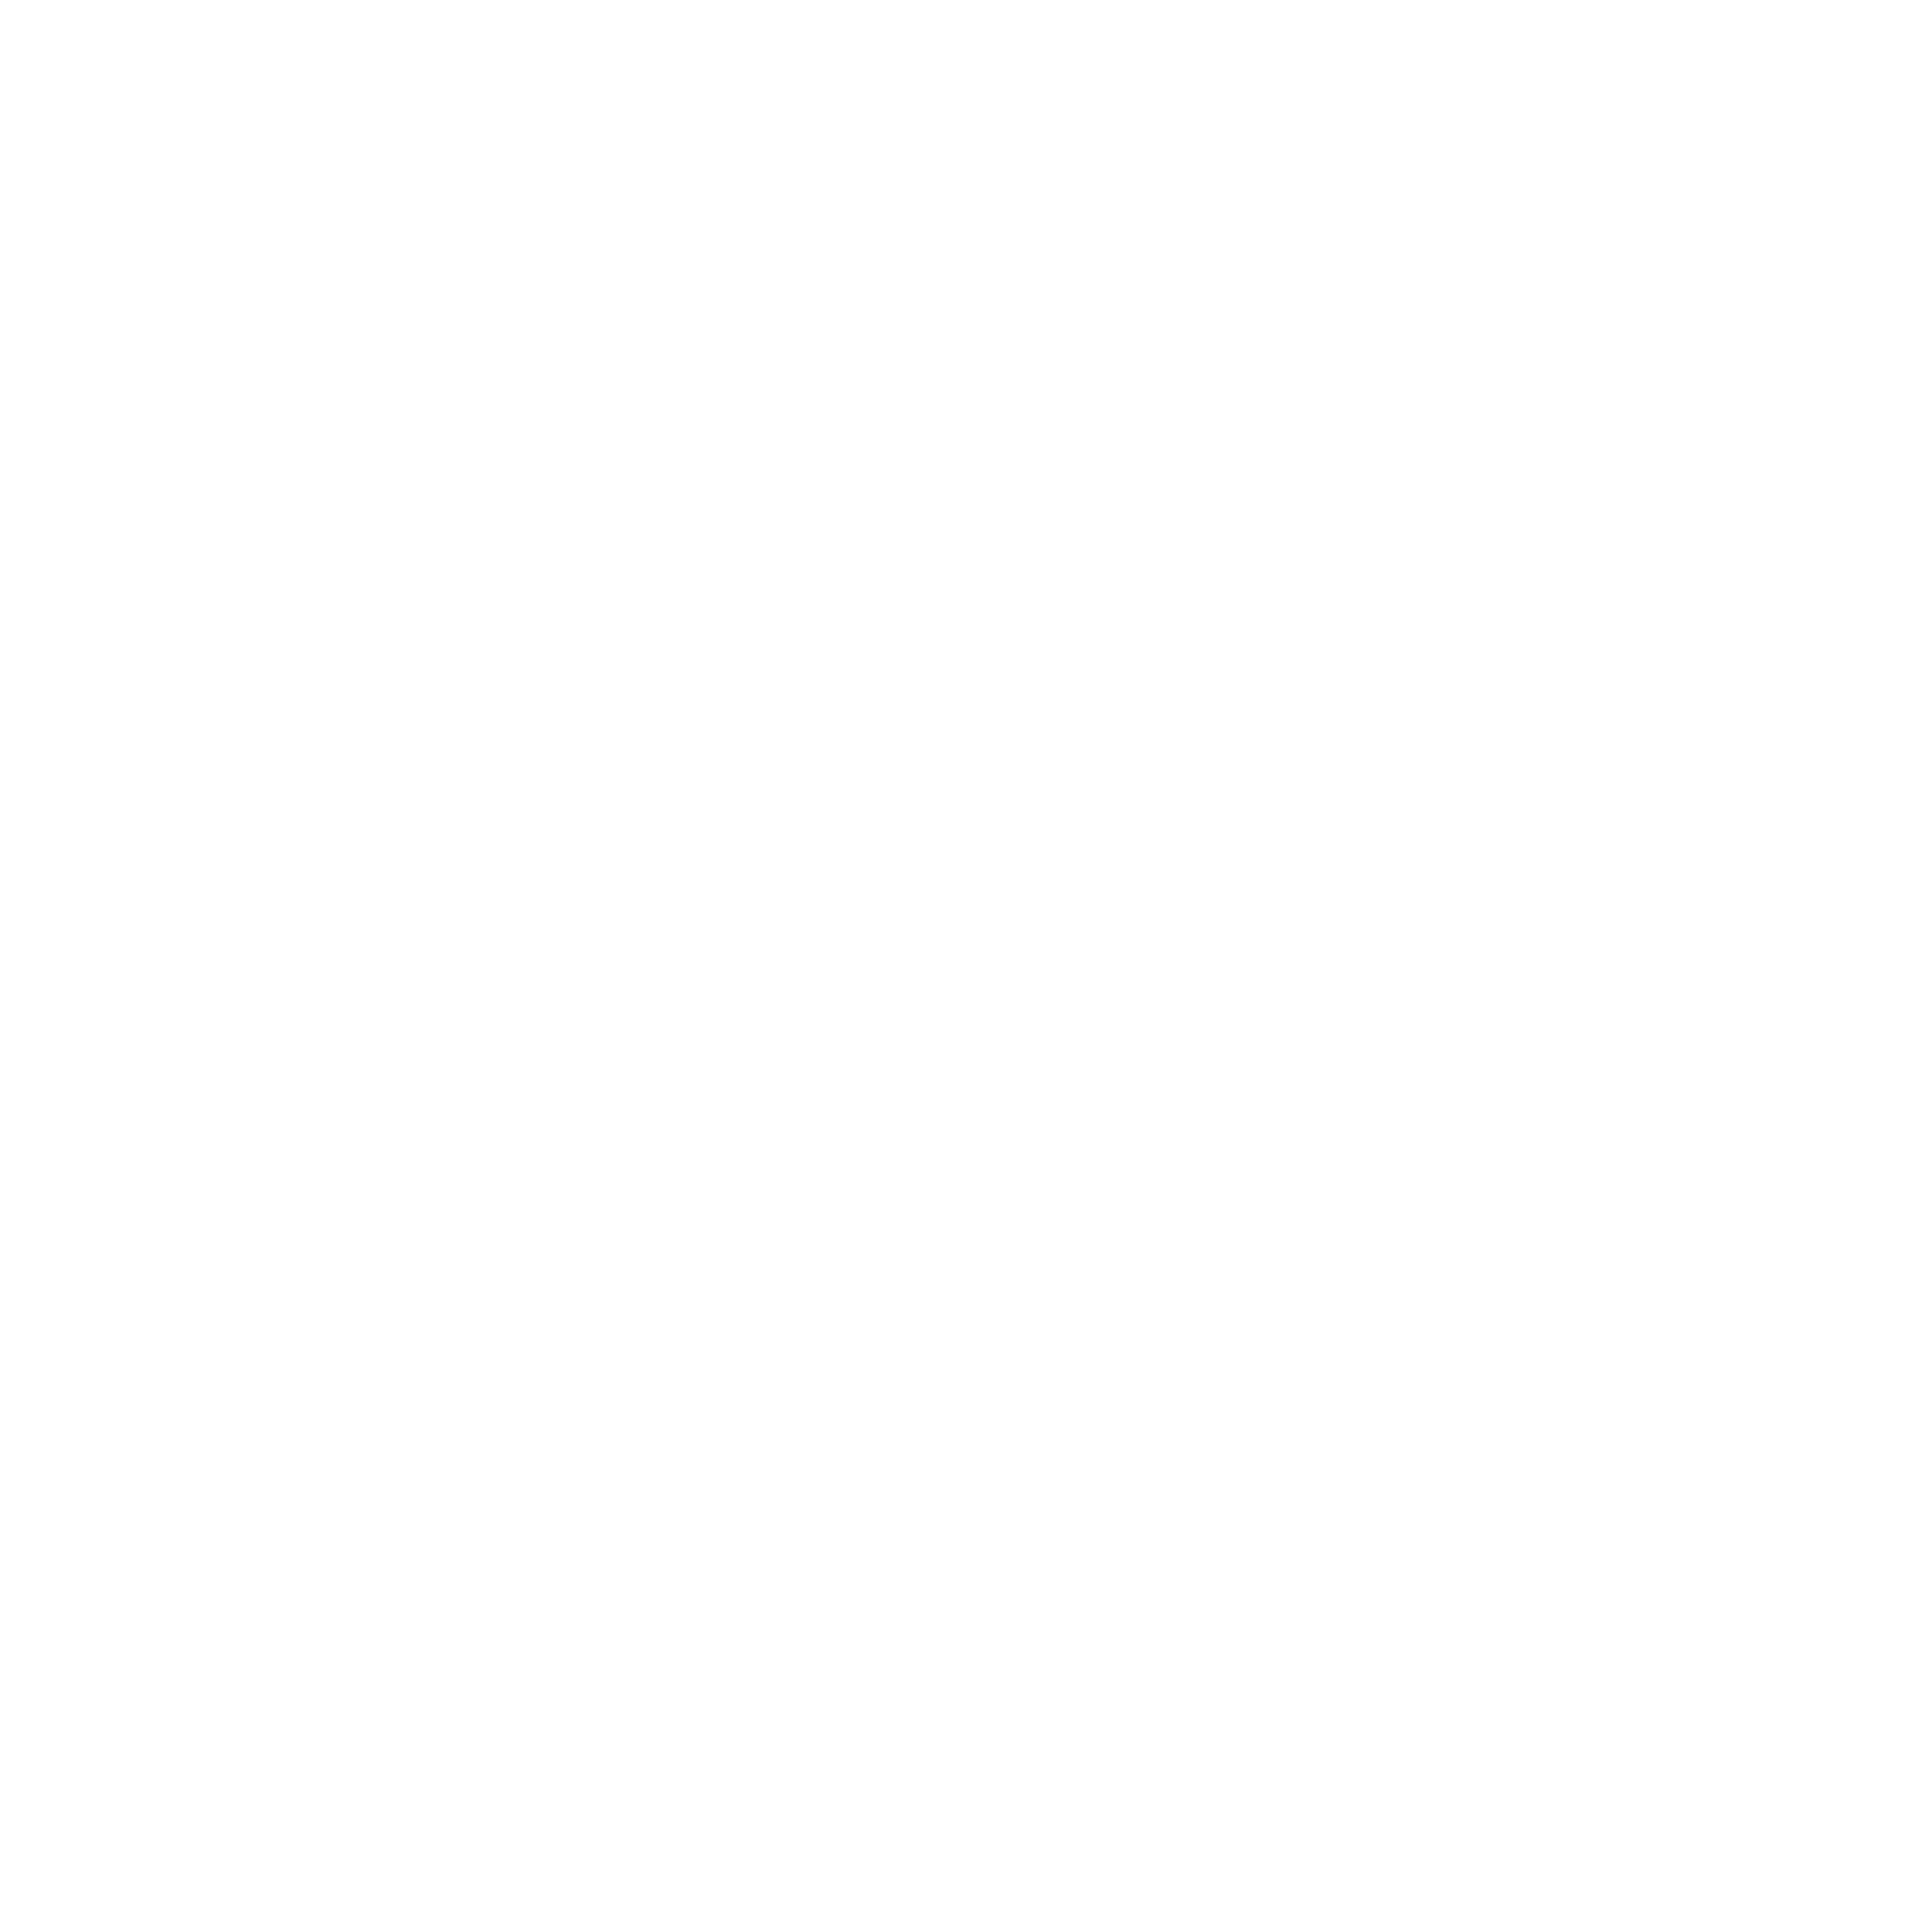

In [45]:
fourier = Figure(resolution = (3000,3000))
c = 0
for (i,abs) in enumerate(abs_vec_fft)
    ax = CairoMakie.Axis(fourier[(c)÷5+1,(c%5)], title = readdir(path)[i])

    lines!(ax, abs, label = "Fourier spectrum")
    
    axislegend(ax2)
    c += 1
end
fourier

In [46]:
hist_vec = mean.(abs_vec_fft)
hist(hist_vec, bins =32)

LoadError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [47]:
abs_vec_fft

Vector{Float64}[]

In [48]:
w_0_f = mean(abs_vec_fft[1:8])
w_24_f = mean(abs_vec_fft[9:16])
w_4_f = mean(abs_vec_fft[17:24])
w_48_f = mean(abs_vec_fft[25:32]);

LoadError: BoundsError: attempt to access 0-element Vector{Vector{Float64}} at index [1:8]

In [49]:
sum_cv_f = [w_0_f,w_4_f,w_24_f,w_48_f]
mean_cv_f = mean.(sum_cv_f)
std_cv_f = std.(sum_cv_f)
start =1

scatty = scatter(start:4,mean_cv_f[start:end])
scatty.axis.ylabel = "CV [σ/μ]"
errorbars!(scatty.axis,start:4,mean_cv_f[start:end], std_cv_f[start:end] )
scatty

LoadError: UndefVarError: `w_0_f` not defined

In [50]:
csize = size(test_vec)
c_vec = zeros( ComplexF32, csize[1] )
    
c_vec[ 1:csize[1]] .= test_vec

fft!(c_vec)

lines(abs2.(c_vec[2:180]))

LoadError: UndefVarError: `test_vec` not defined

In [51]:
coefficents = sum.(abs2.(c_vec[2:180]))

LoadError: UndefVarError: `c_vec` not defined

In [52]:
c_vec[2] 

LoadError: UndefVarError: `c_vec` not defined

In [53]:
c_vec[end]

LoadError: UndefVarError: `c_vec` not defined

In [54]:
ifft!(c_vec)
lines(real.(c_vec))

LoadError: UndefVarError: `c_vec` not defined

In [55]:
real.(c_vec)

LoadError: UndefVarError: `c_vec` not defined

In [56]:
test_vec

LoadError: UndefVarError: `test_vec` not defined

In [57]:
threshold = 0.9
threshold_c = 0.9

rad = 50
kernel = create_kernel(rad)
nneigh = sum(kernel)
images_int = Vector{Matrix{Int}}(undef,0)
centers = Vector{Vector{Int}}(undef, 0)
circles = Vector{Matrix{Int}}(undef,0)
fig_big_cov_c_t = Figure(resolution = (3000,4000))

for (i,pathy) in enumerate(readdir(path))
    img = load(joinpath(path, pathy))
    int_img = b_w(img)
    #rad = Int64(maximum((size(int_img)./9).÷2)*2)
    kernel = create_kernel(rad)
    nneigh = sum(kernel)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    
    ax = CairoMakie.Axis(fig_big_cov_c_t[i÷5+1,i%5+1], title = pathy)
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
    # save data
    push!(images_int, int_img)
    push!(centers,[y_c, x_c])
    push!(circles, circle)
end

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2

In [58]:
path_2 = joinpath(image_data, readdir(image_data)[1])
readdir(path_2)

8-element Vector{String}:
 "Kolonie 1.tif"
 "Kolonie 2.tif"
 "Kolonie 3.tif"
 "Kolonie 4.tif"
 "Kolonie 5.tif"
 "Kolonie 6.tif"
 "Kolonie 7.tif"
 "Kolonie 8.tif"

In [59]:
img_vec_2  = load.(joinpath.(path_2, readdir(path_2)));

In [60]:
fig_big_stacked = Figure(resolution = (4000,3000))
c =0
ang_vec_vec_mask = Vector{Vector{Int64}}(undef,0)
cv_vec = Float64[]

for (i,img_stack) in enumerate(img_vec_2)
    mask = b_w_i.(img_stack[:,:,1])
    y,x = centroid(mask)
    for j in 1:size(img_stack)[3]
        img = b_w_i.(img_stack[:,:,j])
        ax = CairoMakie.Axis(fig_big_stacked[(c)÷5+1,(c%5+1)*2-1], title = "$(readdir(path_2)[i])_$j")
        heatmap!(ax,img, colormap = :algae )
        #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
        heatmap!(ax,mask,colormap =(:thermal,0.5))
        scatter!(ax, y,x, color = :red, markersize = 15)
        
        ax2 = CairoMakie.Axis(fig_big_stacked[(c)÷5+1,(c%5+1)*2], title = "$(readdir(path_2)[i])_$j")
        ang_vec = angular_metric((img.-mask),[y,x],360)
        push!(ang_vec_vec_mask, ang_vec)
        lines!(ax2, [x for x in 1:length(ang_vec)],ang_vec)
        hspan!(ax2, mean(ang_vec)-std(ang_vec),mean(ang_vec)+std(ang_vec), label = "CV = $(round(std(ang_vec)/mean(ang_vec),digits = 3 ))", color = (:red, 0.2))
        axislegend(ax2)
        push!(cv_vec,std(ang_vec)/mean(ang_vec))
        
        
        c += 1
    end
end

save("metric_stacked_cv.png",fig_big_stacked)
fig_big_stacked         
    
    

LoadError: MethodError: no method matching angular_metric(::Matrix{Int64}, ::Vector{Int64}, ::Int64)

[0mClosest candidates are:
[0m  angular_metric(::Any, ::Any; steps)
[0m[90m   @[39m [36mMain[39m [90mC:\Users\Andreas\Dropbox\phd\Image analysis\[39m[90m[4mimage_functions.jl:108[24m[39m


In [61]:
cv_vec_c = [isnan(x) ? 0.0 : x for x in cv_vec ]

Float64[]

In [62]:
sum_vec = [zeros(8) for x in 1:4]
sum_vec[1] = [cv_vec_c[i] for i in 1:4:32]
sum_vec[2] = [cv_vec_c[i] for i in 2:4:32]
sum_vec[3] = [cv_vec_c[i] for i in 3:4:32]    
sum_vec[4] = [cv_vec_c[i] for i in 4:4:32]
sum_vec

LoadError: BoundsError: attempt to access 0-element Vector{Float64} at index [1]

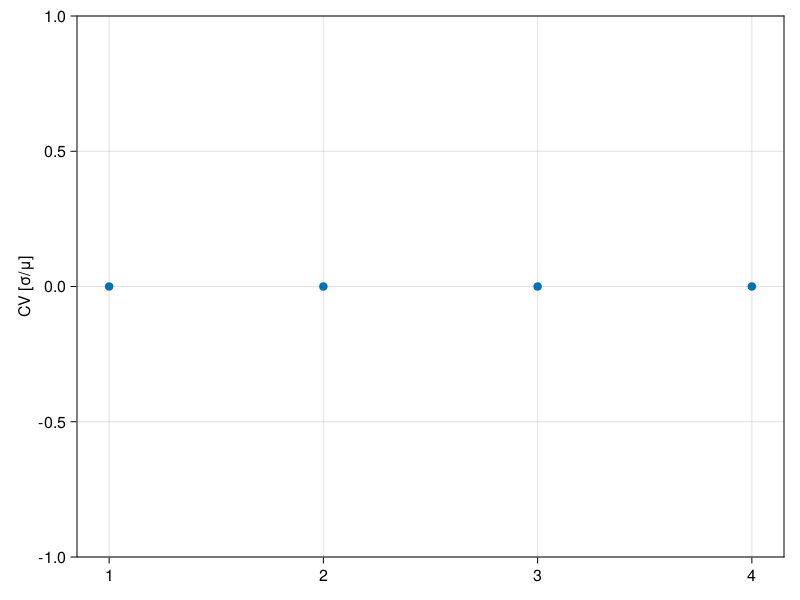

In [63]:

mean_cv = mean.(sum_vec)
std_cv = std.(sum_vec)
start =1

scatty = scatter(start:4,mean_cv[start:end])
scatty.axis.ylabel = "CV [σ/μ]"
errorbars!(scatty.axis,start:4,mean_cv[start:end], std_cv[start:end] )
scatty

In [64]:
rad = 40
threshold = 0.95
threshold_c = 0.9
kernel = create_kernel(rad, geometry = "square")
nneigh = sum(kernel)

fig_big_cov_s_f_m = Figure(resolution = (3000,3000))
img_int_vec_filled = fill_holes.(img_int_vec,[(0.1,1000) for x in length(img_int_vec)])


for (i,int_img) in enumerate(img_int_vec_filled)
    out = conv( int_img, kernel ) ./ nneigh
    y,x = centroid(int_img)
    y_c,x_c = centroid(round.(Int,out.>threshold))
    circle = build_circle([y_c,x_c],int_img,Points,threshold = threshold_c)
    ax = CairoMakie.Axis(fig_big_cov_s_f_m[(i-1)÷5,(i%5)*2-1], title = readdir(path)[i])
    ax2 = CairoMakie.Axis(fig_big_cov_s_f_m[(i-1)÷5,(i%5)*2], title = readdir(path)[i])
    #hidedecorations!(ax)
    heatmap!(ax,int_img, colormap = :algae )
    #heatmap!(ax, out .> threshold, colormap = (:thermal, 0.5) )
    heatmap!(ax,circle,colormap =(:thermal,0.5))
    scatter!(ax, y,x, color = :red, markersize = 15)
    scatter!(ax, y_c, x_c, markersize = 15)
    
  
    ang_vec = angular_metric((int_img.-circle),[y_c,x_c],100)
    lines!(ax2, [x for x in 1:length(ang_vec)],ang_vec)
end
#save("centroid_without_gaus_square_kernel_filled.png", fig_big_cov_s_f)

fig_big_cov_s_f_m

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 3 and 2